In [549]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import random

# Sigmoid Implememtation
Activation Function: $$\frac{1}{1 + e^{-x}}$$

In [550]:
class Node:
    def __init__(self, id, type, parents, weights, neuralNetwork):
        self.id = id
        self.type = type
        self.parents = parents
        self.weights = weights
        self.inputs = {}
        self.output = 0
        self.children = []
        self.neuralNetwork = neuralNetwork
        # print(f"{self.type} node {self.id} created with weights {self.weights}.")
    def setValue(self, setterID, value):
        self.inputs[setterID] = value
        if len(self.inputs) == len(self.weights):
            self.ActivationFunction()

    def AddChildren(self, children):
        self.children = children
        # for child in children:
            # print(f"{child.id} added as child of {self.id}.")
        if self.type == "Hidden" or self.type == "Input":
            if len(children) == 0:
                raise f"{self.type} node added 0 children."

    def ActivationFunction(self):
        # print(f"Activation Function called on {self.id}")
        phi = 0
        if self.type == "Input":
            self.result = self.inputs["neuralNetwork"]
        else:
            if len(self.parents) != len(self.weights):
                raise f"Weights, parents mismatch: weights = {self.weights}, parents: {self.parents}"
            for parent in self.parents:
                phi += self.weights[parent.id] * self.inputs[parent.id]                     # \sum w_i * x_i
            phi += 1
            phi *= -1                                                                        # fixed bias 1
            localResult = 1 / (1 + (np.e ** (phi)))
            self.result = localResult
        if self.children != None:
            for child in self.children:
                child.setValue(setterID=self.id, value=self.result)
        else:
            print(f"Final Output: {self.result}")
        if self.neuralNetwork != None:
            if self.type == "Output":
                self.neuralNetwork.output = self.result
        return self.result
    
    def UpdateWeights(self, previousDelta, eta, desiredOutput):
        if type(previousDelta) != type({"lol" : 0.1}):
            raise f"Unexpected datatype {type(previousDelta)}, expected dict."
        if type(eta) != float and type(eta) != int:
            raise f"Unexpected datatype {type(eta)}, expected int/float."
        if type(desiredOutput) != int and type(desiredOutput) != float:
            raise f"Unexpected datatype {type(desiredOutput)}, expected int/float."
        if (self.type == "Input"):
            pass
        elif (self.type == "Hidden"):
            delta = 0
            childWeights = self.getChildrenWeights()
            for key in childWeights.keys():
                delta += (previousDelta[key] * childWeights[key])
            delta *= (self.result * (1 - self.result))
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (delta * eta * self.inputs[key])
            return delta 
        elif (self.type == "Output"):
            delta = self.result * (1 - self.result) * (desiredOutput - self.result)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (eta * delta * self.inputs[key])
            return delta
        else:
            raise f"Invalid type {self.type}, expected Input/Hidden/Output"

    
    def getChildrenWeights(self):
        weight = {}
        if len(self.children) != 0:
            for child in self.children:
                weight[child.id] = child.weights[self.id]
        return weight
                
    

# ReLu Implementation
Activation function: $$max(0,x)$$


In [551]:
class ReLUNode(Node):
    def ActivationFunction(self):
        # print(f"Activation Function called on {self.id}")
        phi = 0
        if self.type == "Input":
            self.result = self.inputs["neuralNetwork"]
        else:
            if len(self.parents) != len(self.weights):
                raise f"Weights, parents mismatch: weights = {self.weights}, parents: {self.parents}"
            for parent in self.parents:
                phi += self.weights[parent.id] * self.inputs[parent.id]                     # \sum w_i * x_i
            phi += 1                                                                        # fixed bias 1
            localResult = max(0, phi)
            self.result = localResult
        if self.children != None:
            for child in self.children:
                child.setValue(setterID=self.id, value=self.result)
        else:
            print(f"Final Output: {self.result}")
        if self.neuralNetwork != None:
            if self.type == "Output":
                self.neuralNetwork.output = self.result
        return self.result
    
    def UpdateWeights(self, previousDelta, eta, desiredOutput):
        if type(previousDelta) != type({"lol" : 0.1}):
            raise f"Unexpected datatype {type(previousDelta)}, expected dict."
        if type(eta) != float and type(eta) != int:
            raise f"Unexpected datatype {type(eta)}, expected int/float."
        if type(desiredOutput) != int and type(desiredOutput) != float:
            raise f"Unexpected datatype {type(desiredOutput)}, expected int/float."
        if (self.type == "Input"):
            pass
        elif (self.type == "Hidden"):
            delta = 0
            childWeights = self.getChildrenWeights()
            for key in childWeights.keys():
                delta += (previousDelta[key] * childWeights[key])
            delta *= max(0, delta + 1)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (delta * eta * self.inputs[key])
            return delta 
        elif (self.type == "Output"):
            phi = 0
            for key in self.weights.keys():
                phi += self.weights[key] * self.inputs[key]
            delta = max(0, phi + 1) * (desiredOutput - self.result)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (eta * delta * self.inputs[key] * self.inputs[key])
            return delta
        else:
            raise f"Invalid type {self.type}, expected Input/Hidden/Output"

                
    

## Tanh Implementation
Activation Function:
$$\tanh (x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

In [697]:
class TanhNode(Node):
    def ActivationFunction(self):
        # print(f"Activation Function called on {self.id}")
        if self.type == "Input":
            self.result = self.inputs["neuralNetwork"]
        else:
            if len(self.parents) != len(self.weights):
                raise f"Weights, parents mismatch: weights = {self.weights}, parents: {self.parents}"
            phi = 1                                                                        # fixed bias 1
            for parent in self.parents:
                phi += self.weights[parent.id] * self.inputs[parent.id]                     # \sum w_i * x_i + 1
            localResult = np.tanh(phi)
            self.result = localResult
        if self.children != None:
            for child in self.children:
                child.setValue(setterID=self.id, value=self.result)
        else:
            print(f"Final Output: {self.result}")
        if self.neuralNetwork != None:
            if self.type == "Output":
                self.neuralNetwork.output = self.result
        return self.result
    
    def UpdateWeights(self, previousDelta, eta, desiredOutput):
        if type(previousDelta) != type({"lol" : 0.1}):
            raise f"Unexpected datatype {type(previousDelta)}, expected dict."
        if type(eta) != float and type(eta) != int:
            raise f"Unexpected datatype {type(eta)}, expected int/float."
        if type(desiredOutput) != int and type(desiredOutput) != float:
            raise f"Unexpected datatype {type(desiredOutput)}, expected int/float."
        if (self.type == "Input"):
            pass
        elif (self.type == "Hidden"):
            delta = 0
            childWeights = self.getChildrenWeights()
            for key in childWeights.keys():
                delta += (previousDelta[key] * childWeights[key])
            delta *= (1 - (self.output ** 2))
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (delta * eta * self.inputs[key])
            return delta
        elif (self.type == "Output"):
            delta = (1 - self.output ** 2) * (desiredOutput - self.result)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (eta * delta * self.inputs[key])
            return delta
        else:
            raise f"Invalid type {self.type}, expected Input/Hidden/Output"


In [596]:
def NodePicker(type):
    if type == "Sigmoid":
        return Node
    elif type == "ReLU":
        return ReLUNode
    elif type == "Tanh":
        return TanhNode
    else:
        raise "type unknown, valid options \"Sigmoid\", \"Tanh\" and \"ReLU\""

In [677]:
random.seed(a=12)

class NeuralNetwork:
    def __init__(self, inputCount, hiddenlayerWidth, hiddenLayerDepth, outputCount, activationFunction):
        if type(hiddenLayerDepth) != int or type(hiddenlayerWidth) != int or type(outputCount) != int or type(inputCount) != int:
            raise "All inputs are supposed to be integer."
        self.id = "neuralNetwork"
        self.output = 0
        currentLayer = []
        parentLayer = []
        layerCounter = 0
        for nodeNumber in range(1, inputCount + 1):
            currentLayer.append(NodePicker(activationFunction)(id=f"({layerCounter},{nodeNumber})", type="Input", parents=[self], weights={self.id: 1}, neuralNetwork=self))
        self.networkHead = currentLayer
        for hiddenLayerNumber in range(1, hiddenLayerDepth + 1):
            parentLayer = currentLayer
            currentLayer = []
            for nodeNumber in range(1, hiddenlayerWidth + 1):
                weights = {}
                for parent in parentLayer:
                    weights[parent.id] = random.random()
                node = NodePicker(activationFunction)(id=f"({hiddenLayerNumber}, {nodeNumber})", type="Hidden", parents=parentLayer, weights=weights, neuralNetwork=self)
                currentLayer.append(node)
            for parent in parentLayer:
                parent.AddChildren(currentLayer)
        parentLayer = currentLayer
        currentLayer = []
        layerCounter += (hiddenLayerDepth + 1)
        for outputCount in range(1, outputCount + 1):
            weights = {}
            for parent in parentLayer:
                weights[parent.id] = random.random()
            node = NodePicker(activationFunction)(id=f"({layerCounter}, {outputCount})", type="Output", parents=parentLayer, neuralNetwork=self, weights=weights)
            currentLayer.append(node)
        for parent in parentLayer:
            parent.AddChildren(children=currentLayer)
        self.outputLayer = currentLayer
    
    def GetError(self, inputs, outputs):
        if len(inputs) != len(outputs):
            raise f"Input output count mismatch. Input: {len(inputs)} Output: {len(outputs)}."
        nnOutput = []
        error = []
        for input in inputs:
            self.networkHead[0].setValue(setterID = self.id, value = input[0])
            self.networkHead[1].setValue(setterID = self.id, value = input[1])
            nnOutput.append(self.output)
        for i in range(0, len(outputs)):
            error.append((nnOutput[i] - outputs[i]) * (nnOutput[i] - outputs[i]))
        return error

    def BackTrack(self, learningRate, desiredOutput):
        if len(self.outputLayer) == 0:
            raise "No output layer to backtrack from."
        currentLayer = self.outputLayer
        previousDelta = {}
        deltaLayer = {}
        while type(currentLayer[0]) != type(self):
            for node in currentLayer:
                delta = node.UpdateWeights(previousDelta=previousDelta, eta = learningRate, desiredOutput = desiredOutput)
                deltaLayer[node.id] = delta
            previousDelta = deepcopy(deltaLayer)
            deltaLayer.clear()
            currentLayer = currentLayer[0].parents

    def FlushNeuralNetwork(self):
        currentLayer = self.networkHead
        while len(currentLayer) != 0:
            for node in currentLayer:
                node.inputs.clear()
            currentLayer = currentLayer[0].children

    def Train(self, epoches, inputs, outputs, learningRate):
        errors = []
        nnOutputs = []
        for i in range(1, epoches + 1):
            temporaryErrors = 0
            for j in range(len(inputs)):
                self.networkHead[0].setValue(setterID=self.id, value=inputs[j][0])
                self.networkHead[1].setValue(setterID=self.id, value=inputs[j][1])
                temporaryErrors += ((self.output - outputs[j]) * (self.output - outputs[j]))
                # print(f"Desired input and output: {input[j][0], input[j][1]}, {output[j]}")
                self.BackTrack(learningRate=learningRate, desiredOutput=outputs[j])
                nnOutputs.append(self.output)
                self.FlushNeuralNetwork()
            temporaryErrors /= len(outputs)
            errors.append(temporaryErrors)
        return errors, nnOutputs



In [706]:
# learningRate = 0.45
# Epochs = 8000
from numpy import negative


noisyInput = [[0.1, 0.1],
        [0.1, 1],
        [1, 0.1],
        [1, 1]]
standardInput = [[0, 0],
                [0, 1],
                [1, 0],
                [1, 1]]

input = noisyInput                      #pick Noisy or Standard input
normalOutput = [0, 1, 1, 0]
negativeOutput = [0, -1, -1, 0]
output = normalOutput

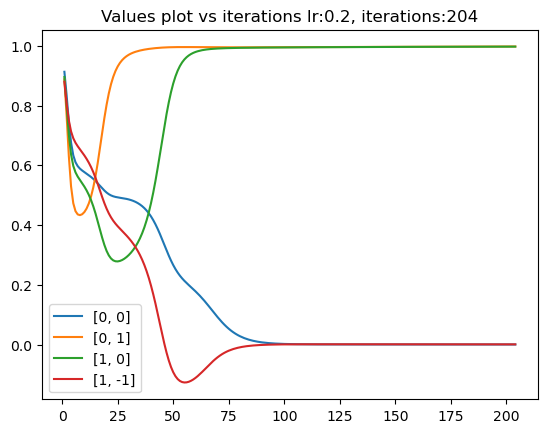

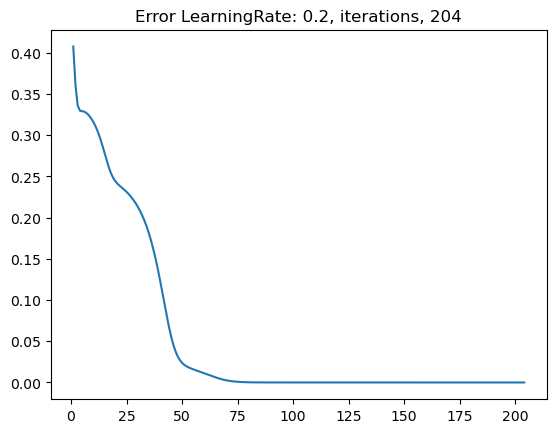

99.99967291052741% accurate


In [718]:
import functools

def plotGraphs(lr, iterations, nodeType):
    nn = NeuralNetwork(inputCount=2, hiddenlayerWidth=2, hiddenLayerDepth=1, outputCount=1, activationFunction=nodeType)
    nn.outputLayer[0].weights
    nn.FlushNeuralNetwork()
    errors, nnOutputs = nn.Train(epoches=iterations, inputs=input, outputs=output, learningRate=lr)
    outputDict = {}
    for index in range(len(nnOutputs)):
            if outputDict.keys().__contains__(str(input[index % 4])):
                outputDict[str(input[index % 4])].append(nnOutputs[index])
            else:
                outputDict[str(input[index % 4])] = [nnOutputs[index]]
    for key in outputDict.keys():
        plt.plot(range(1, len(outputDict[key]) + 1), outputDict[key], label=key)
    plt.legend()
    plt.title(f"Values plot vs iterations lr:{lr}, iterations:{iterations}")
    plt.savefig(f"Figures/{nodeType}/Values/Values plot vs iterations lr:{lr}, iterations:{iterations}.jpg")
    plt.show()
    errors = np.array(errors)
    plt.plot(range(1, len(errors) +1), errors)
    plt.title(f"Error LearningRate: {lr}, iterations, {iterations}")
    plt.savefig(f"Figures/{nodeType}/Errors/Error LearningRate: {lr}, iterations, {iterations}.jpg")
    plt.show()
    finalError = nn.GetError(inputs=input, outputs=output)
    fel = len(finalError)
    finalError = functools.reduce(lambda a, b: a + b, finalError)
    return finalError/fel

finalError = plotGraphs(0.2, 204, "Tanh")
print(f"{(1 - finalError) * 100}% accurate")

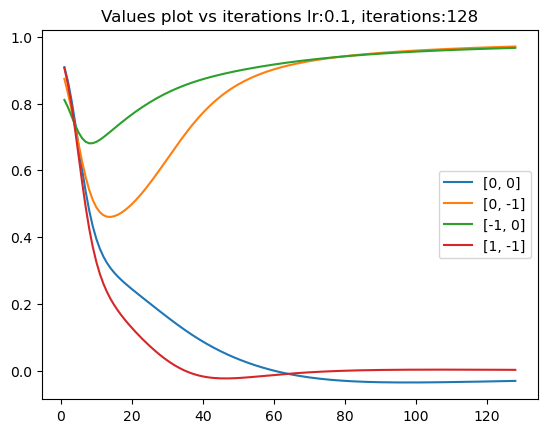

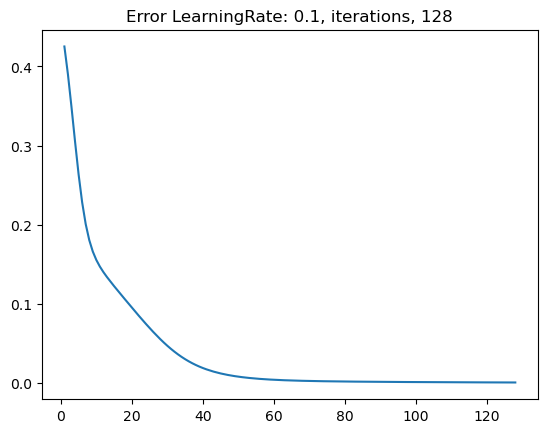

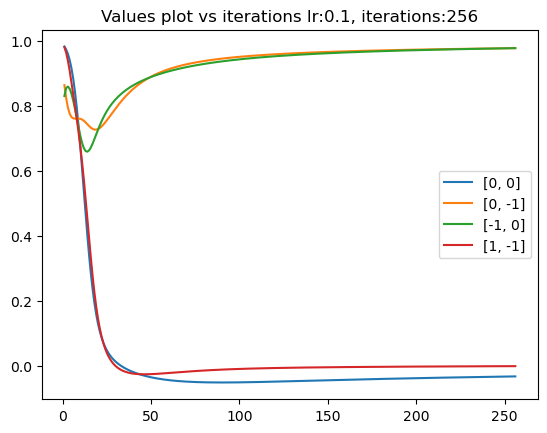

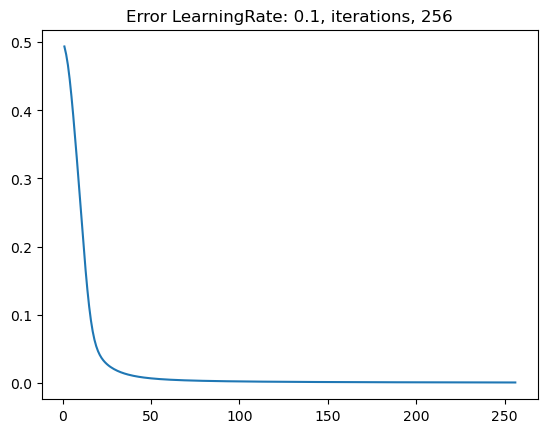

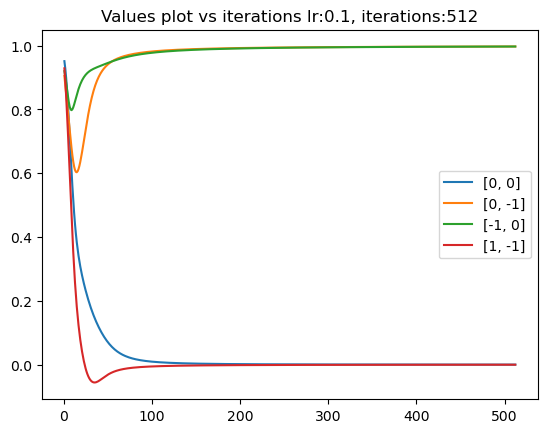

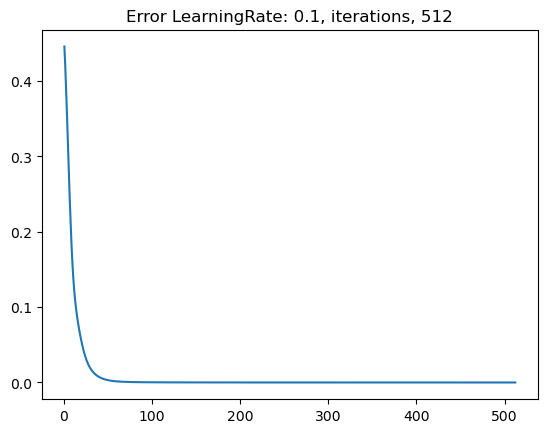

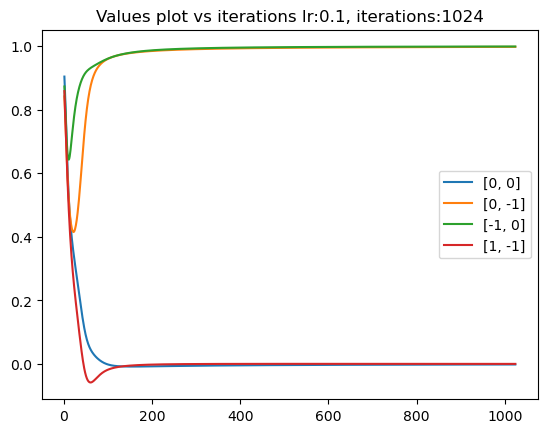

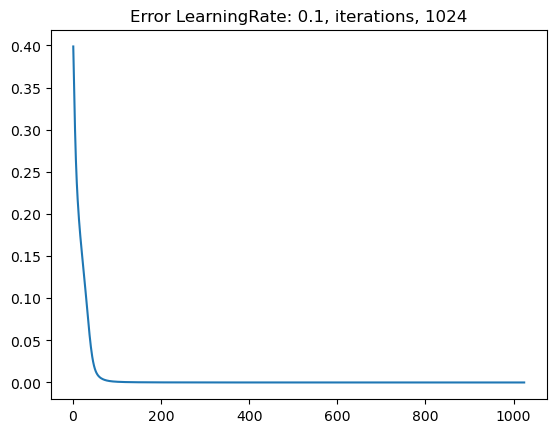

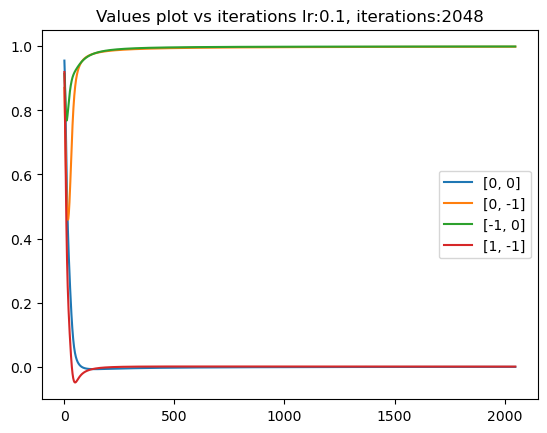

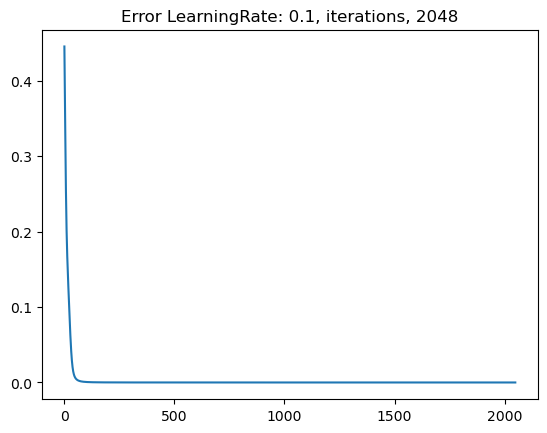

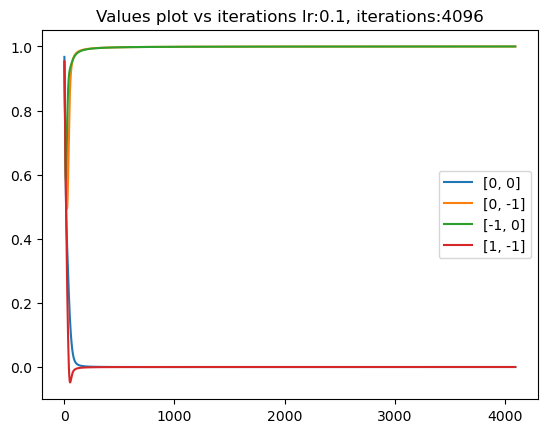

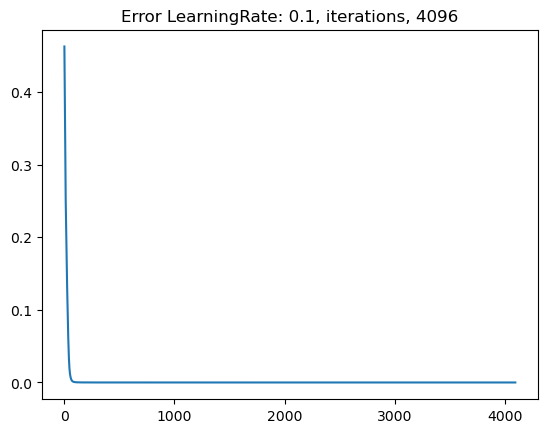

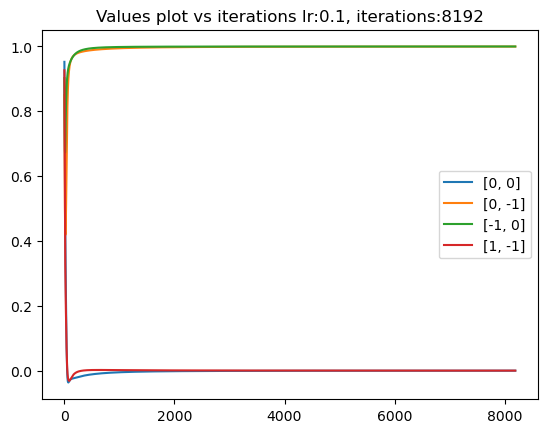

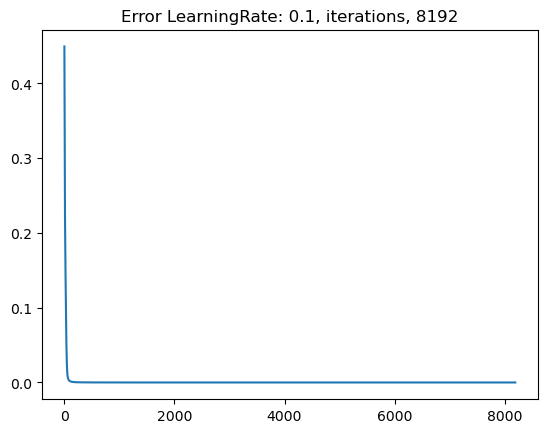

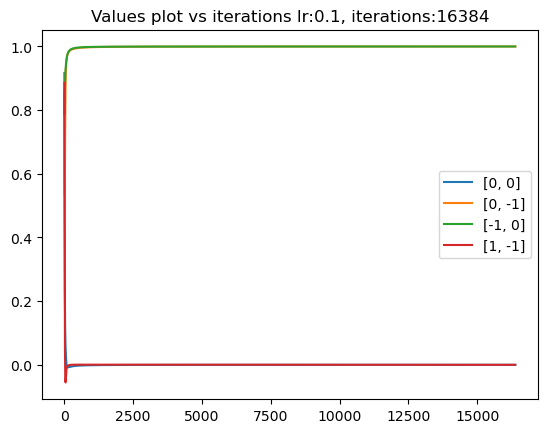

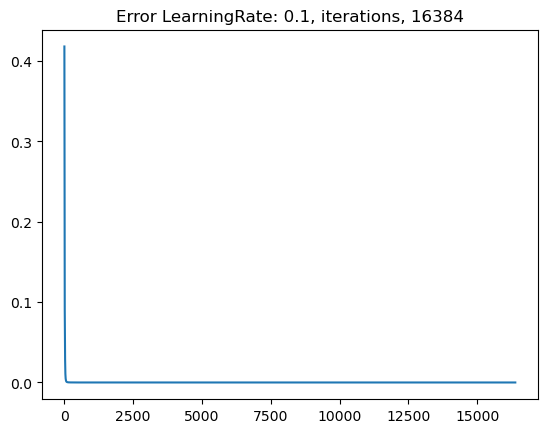

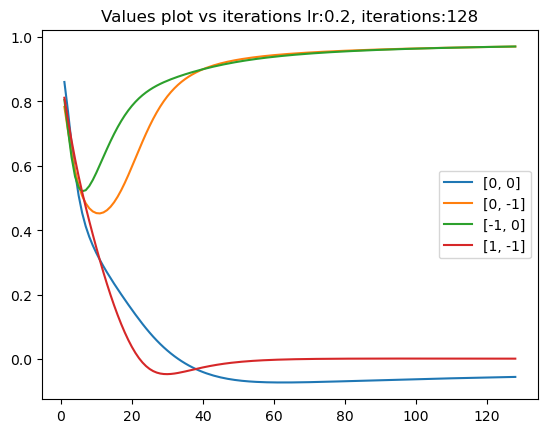

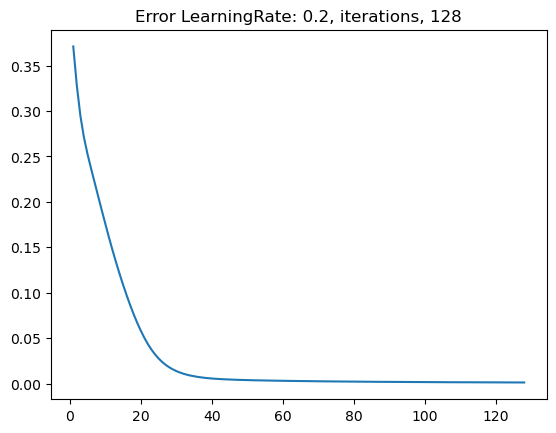

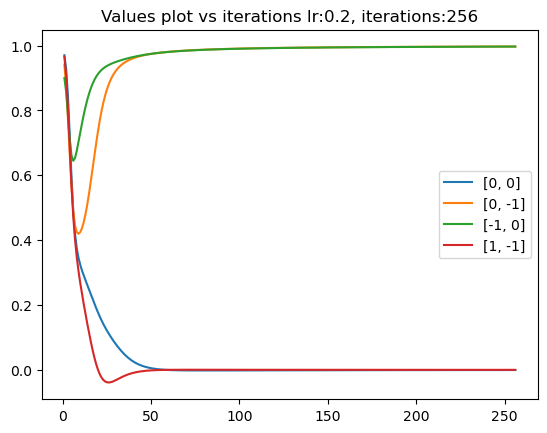

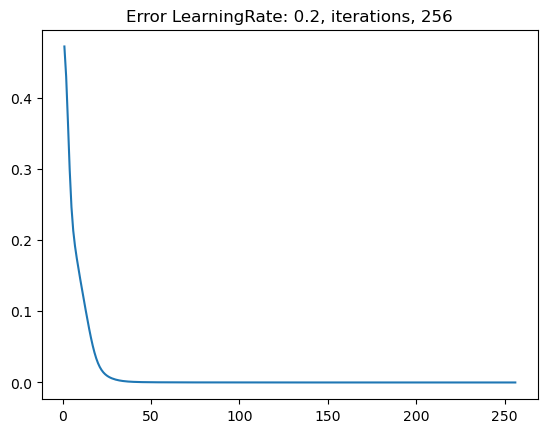

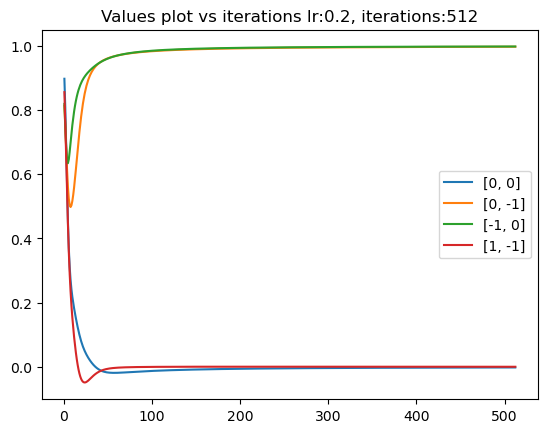

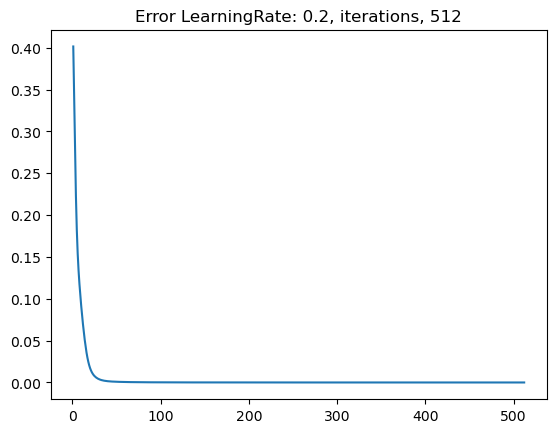

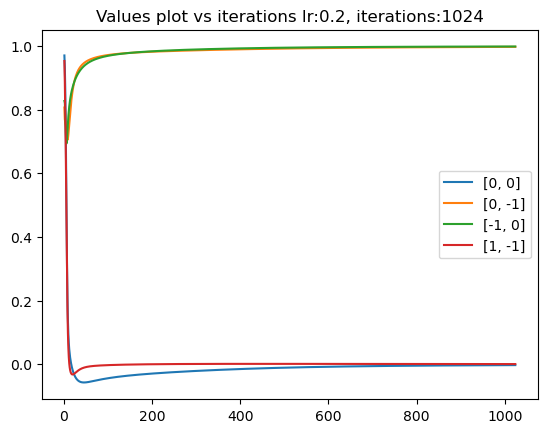

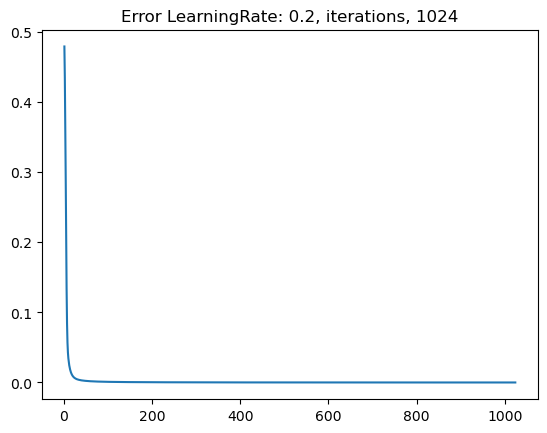

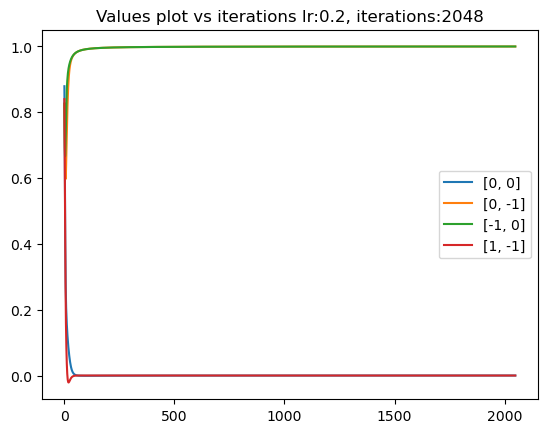

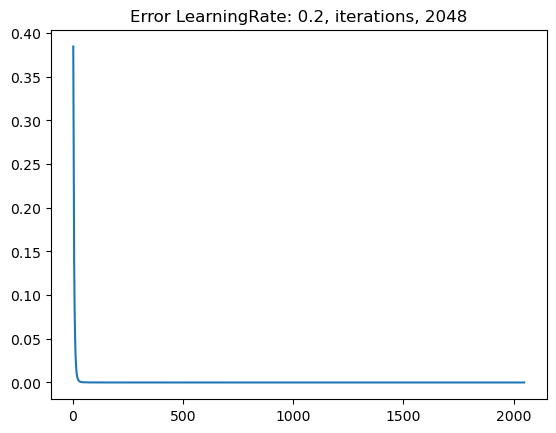

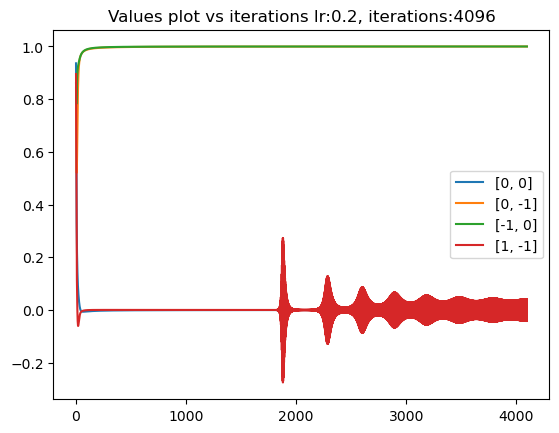

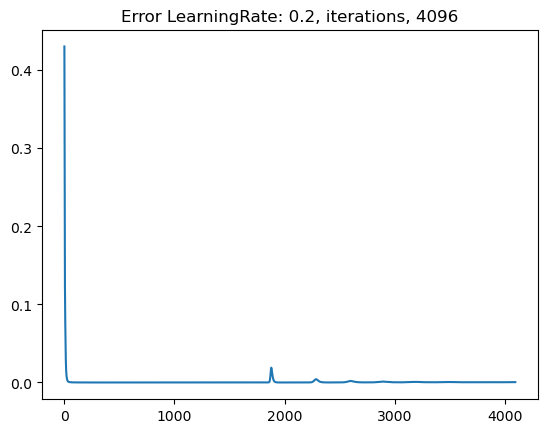

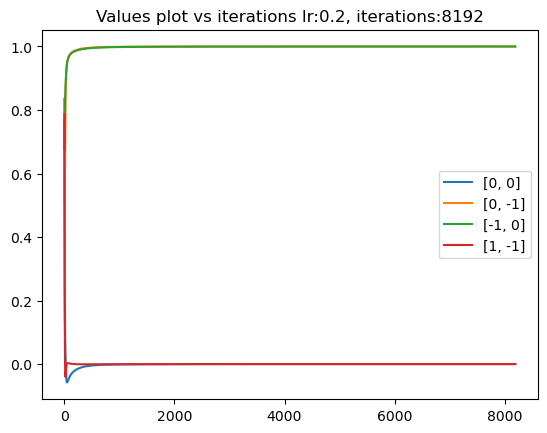

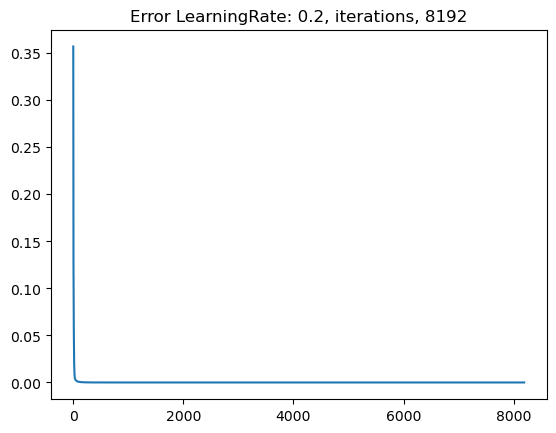

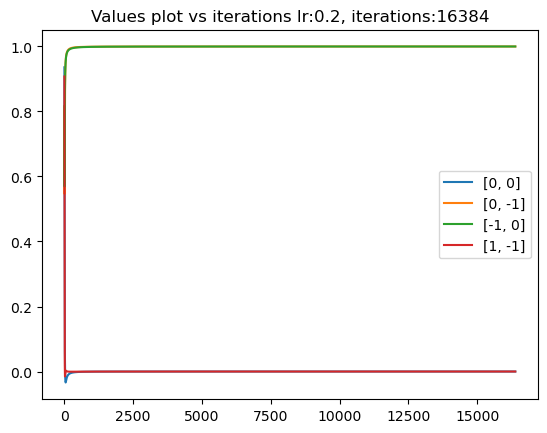

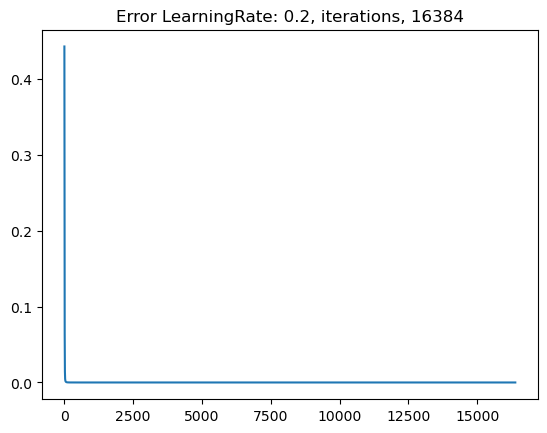

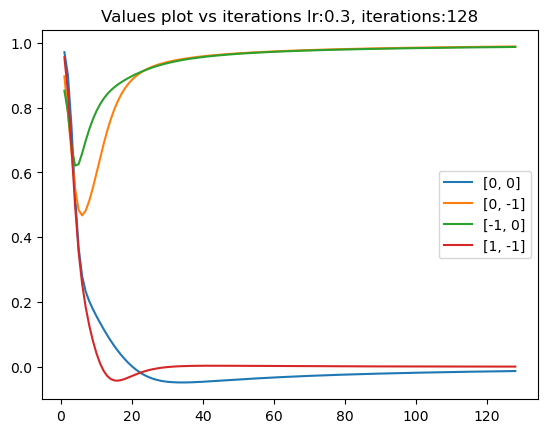

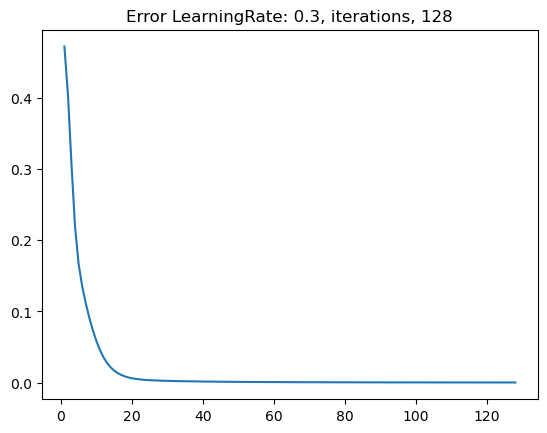

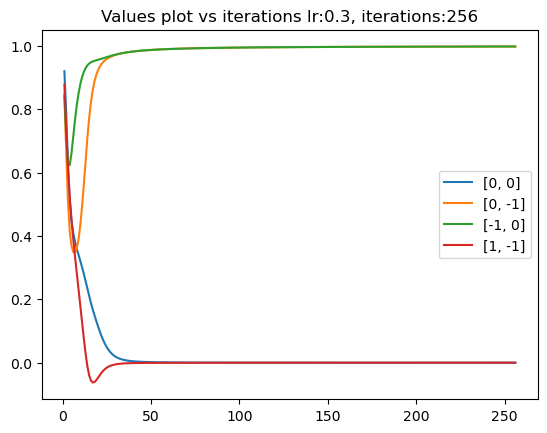

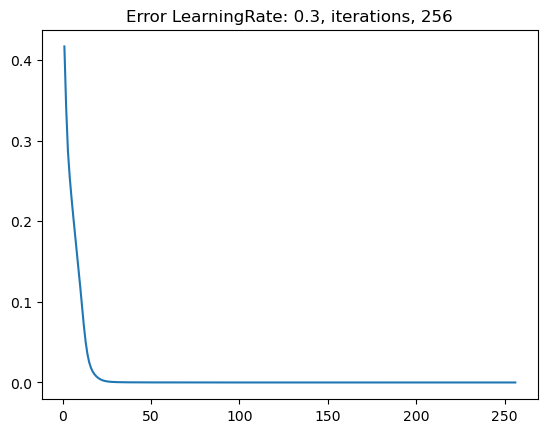

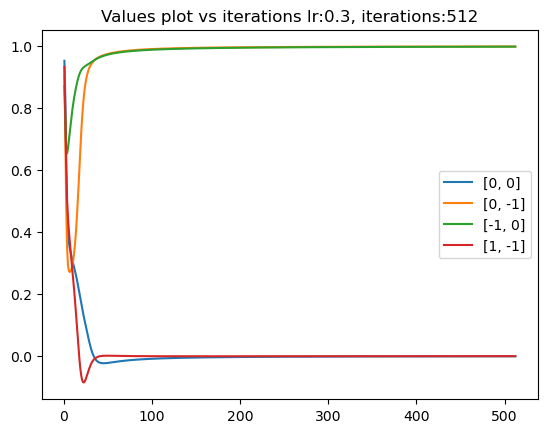

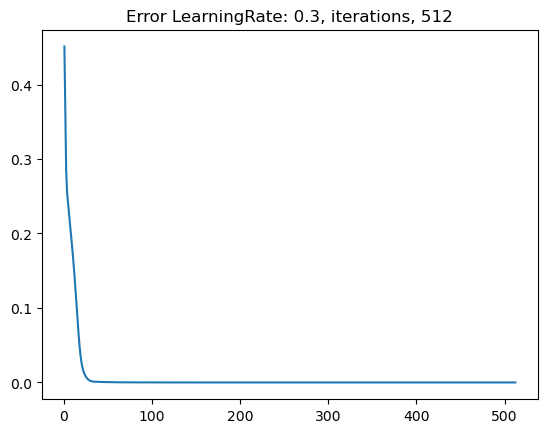

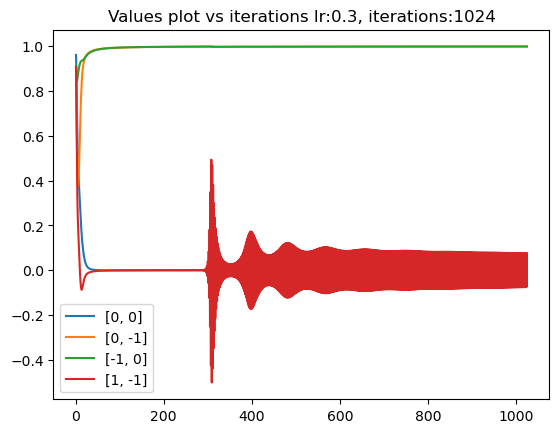

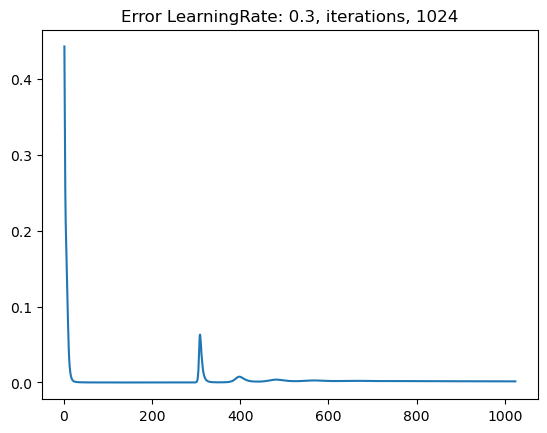

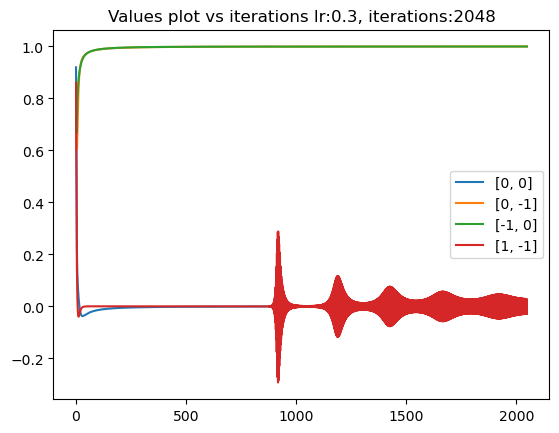

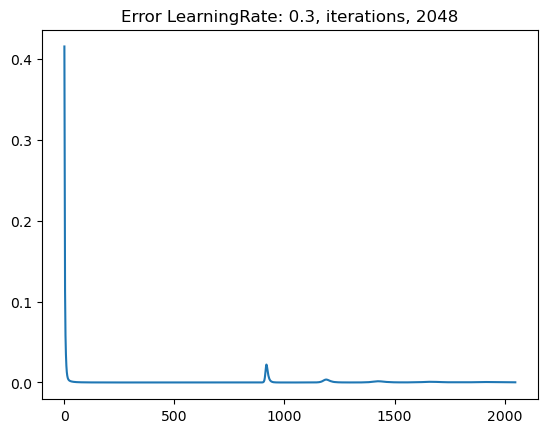

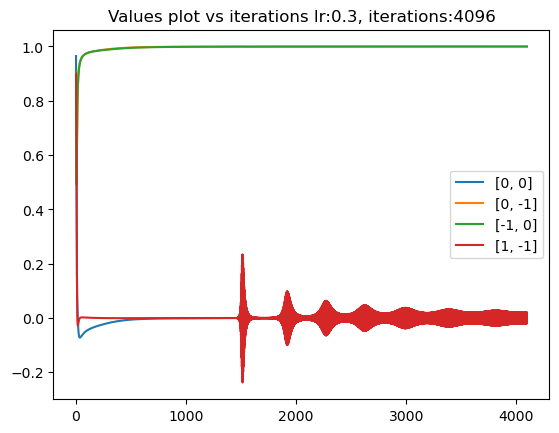

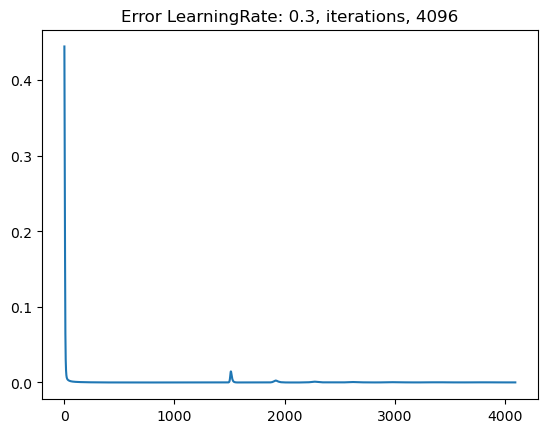

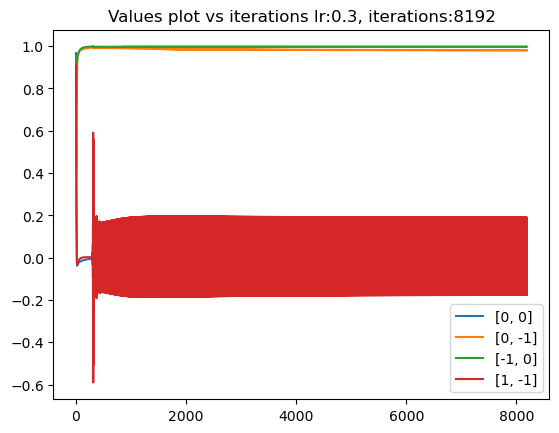

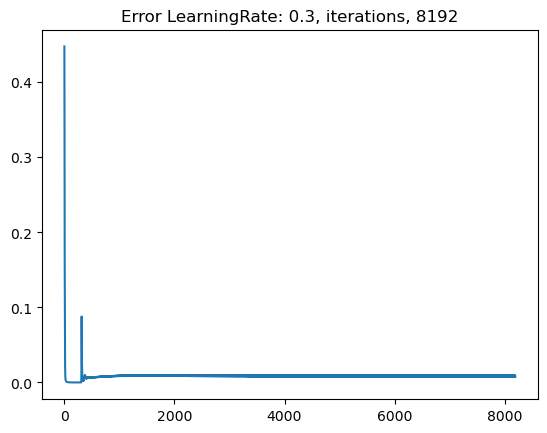

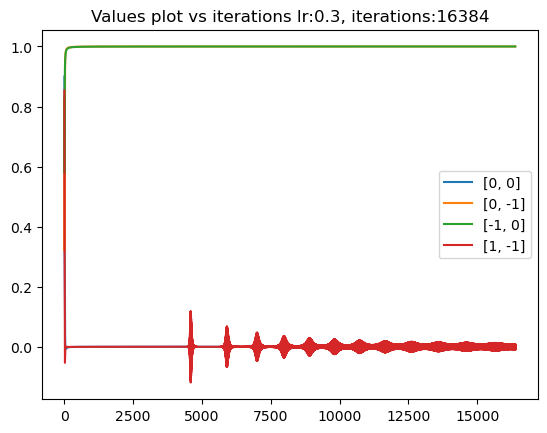

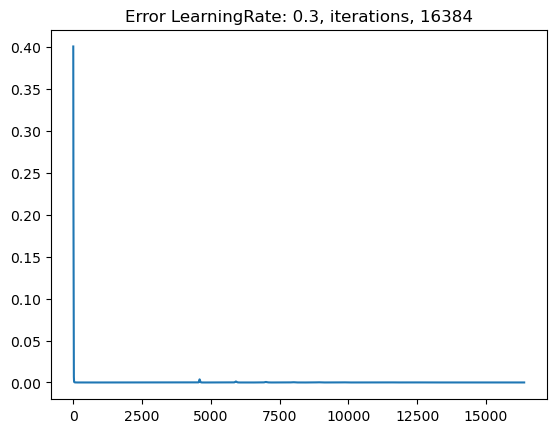

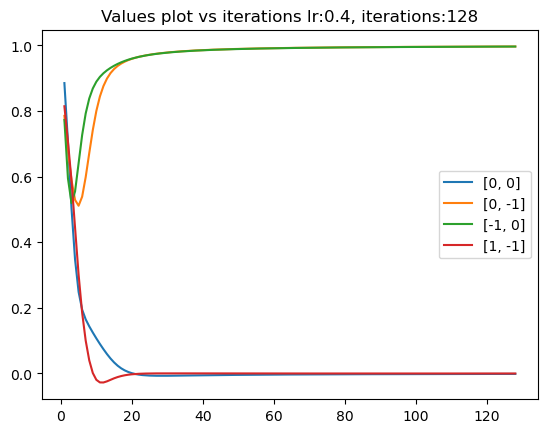

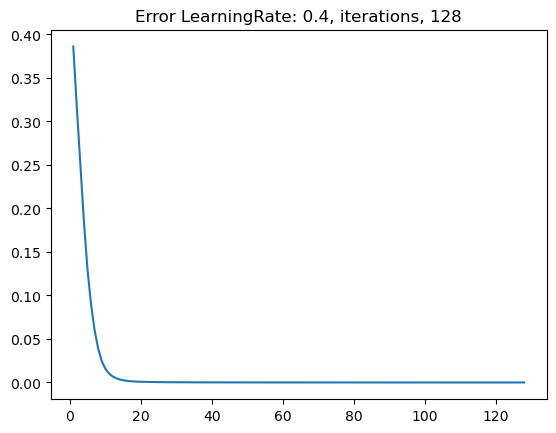

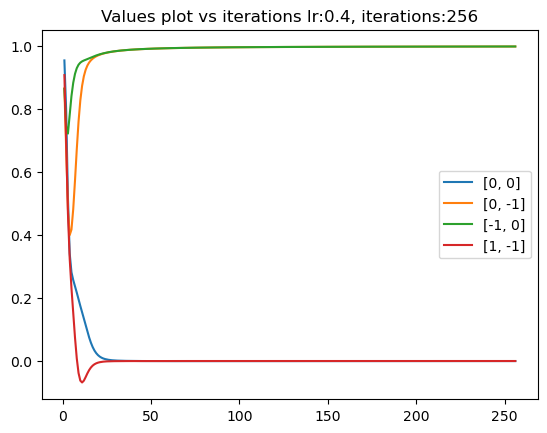

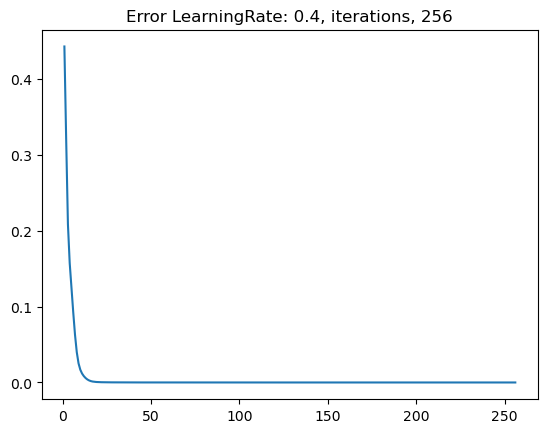

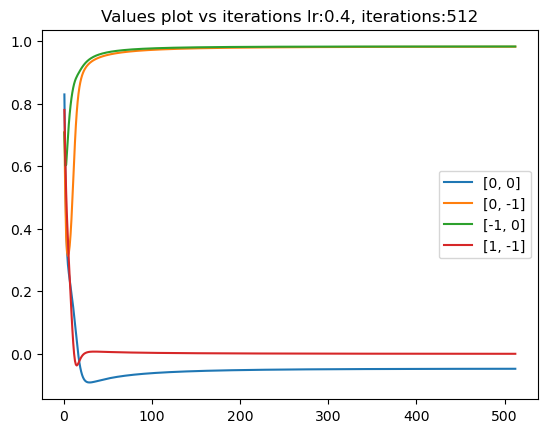

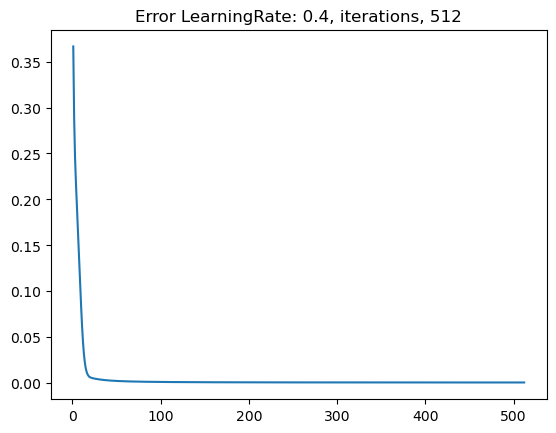

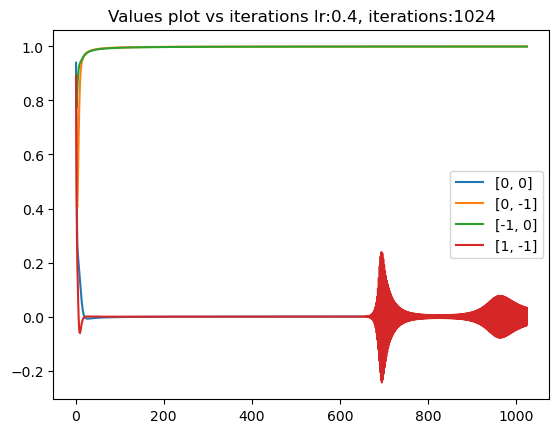

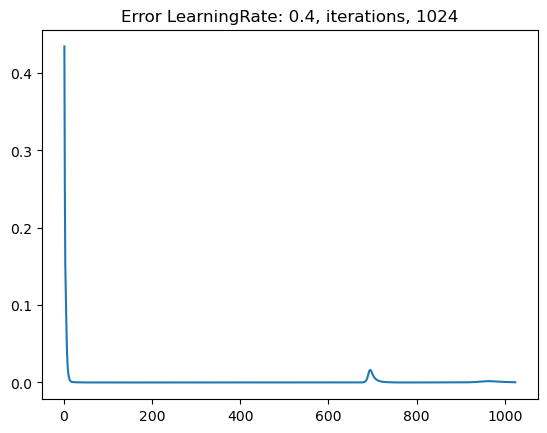

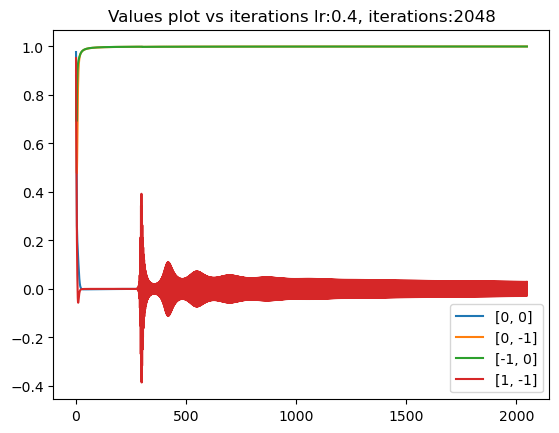

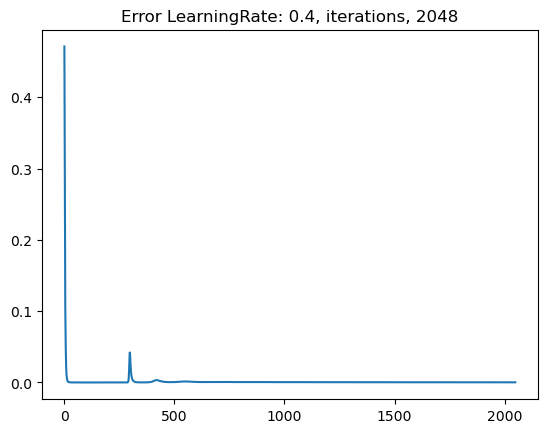

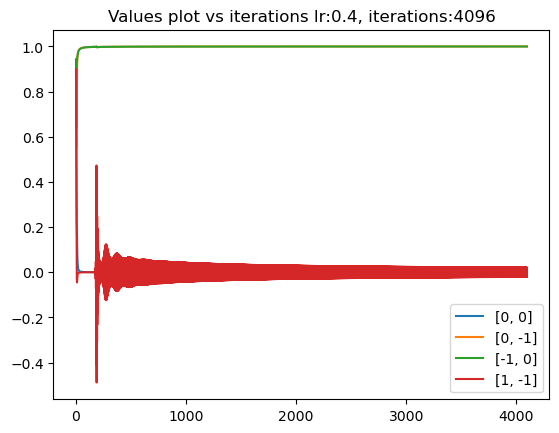

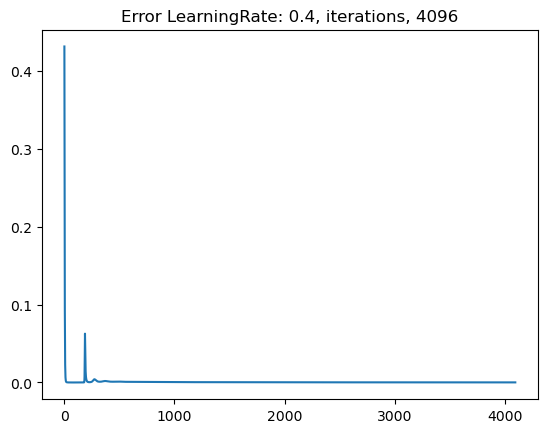

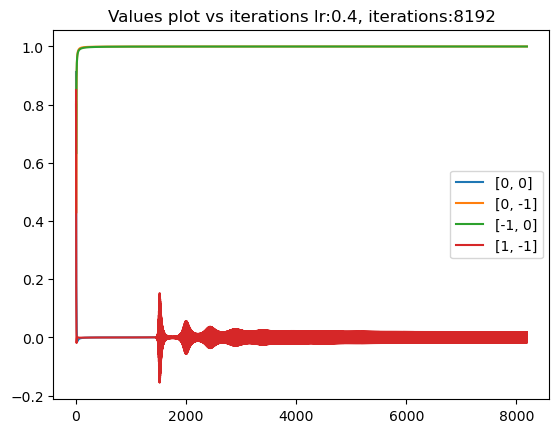

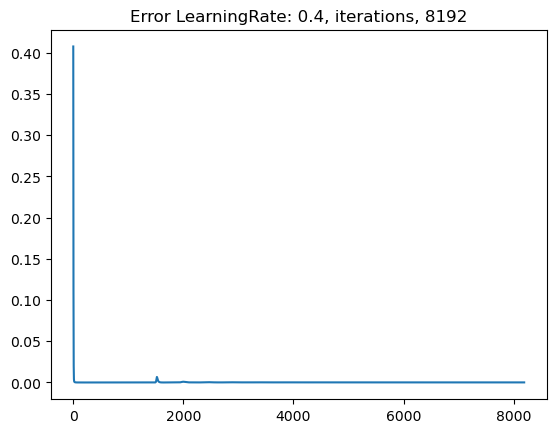

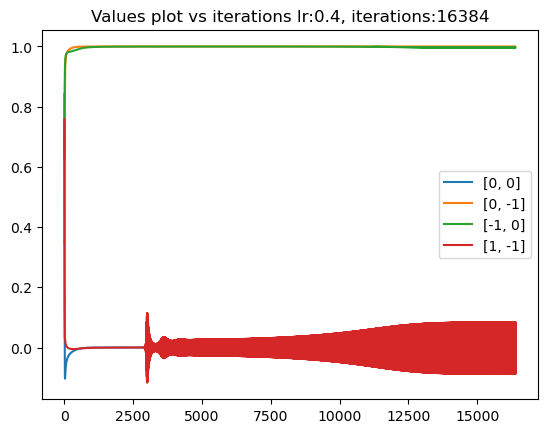

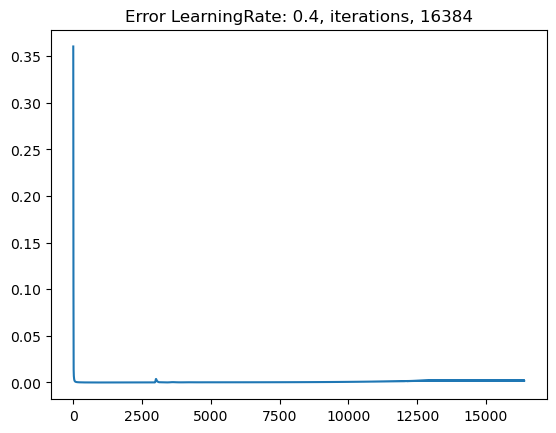

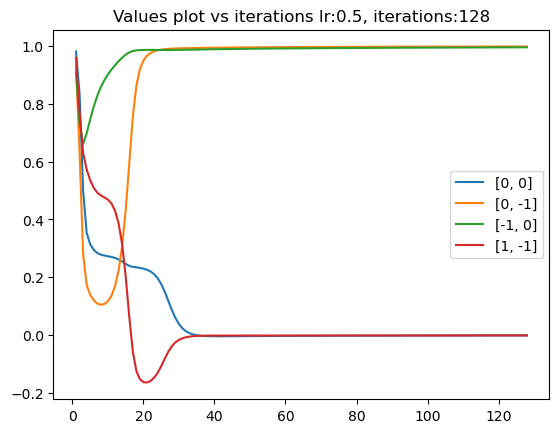

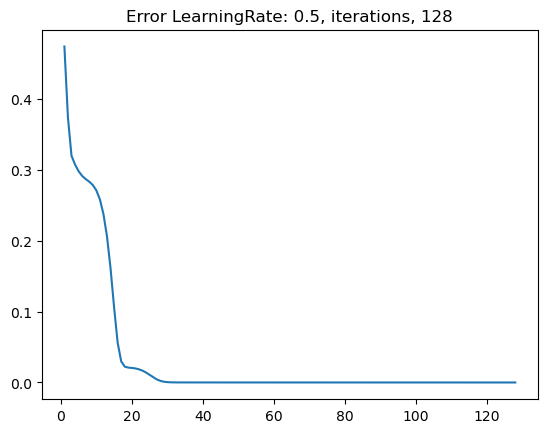

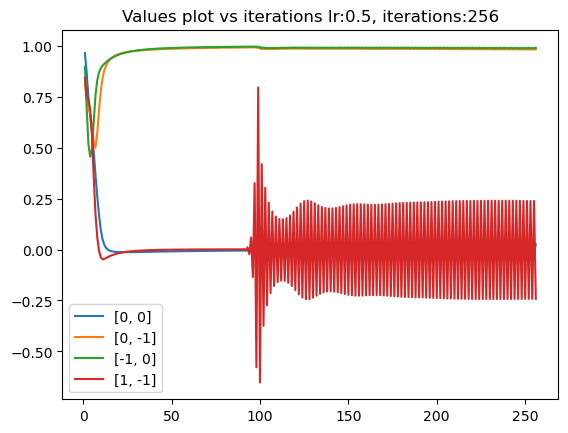

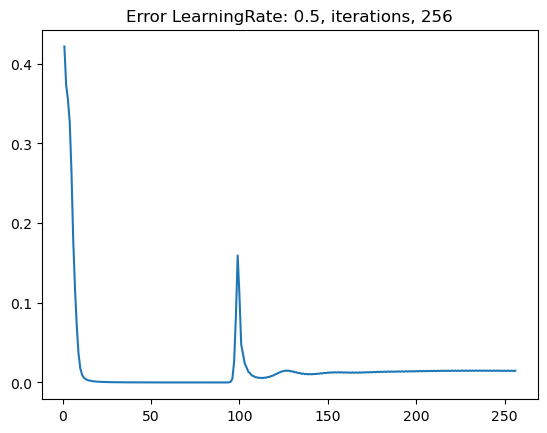

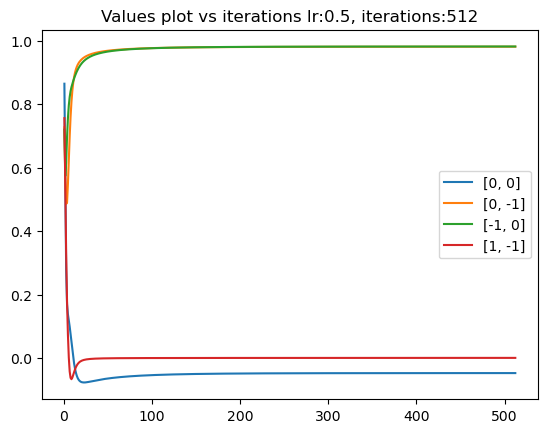

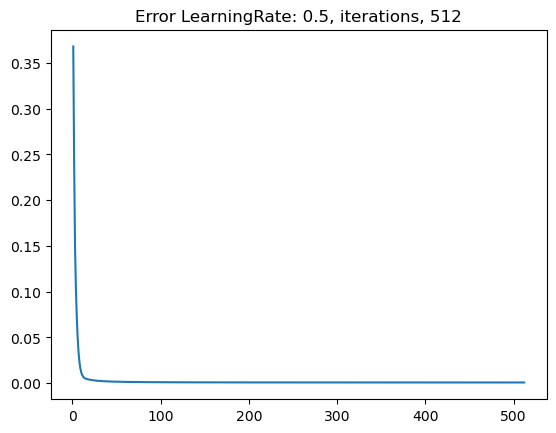

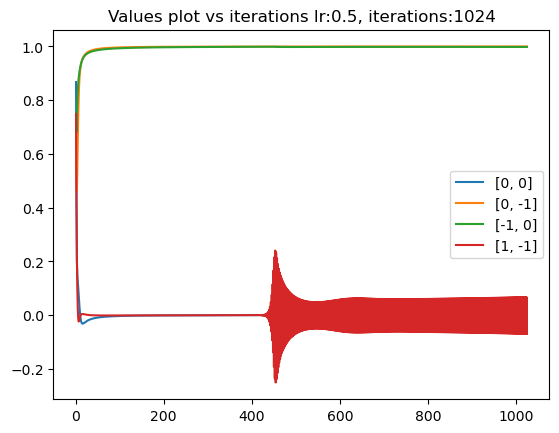

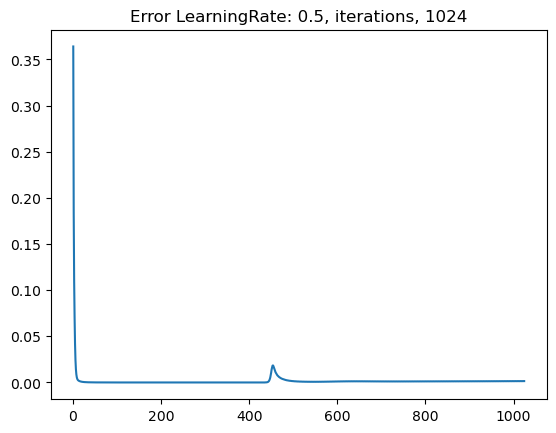

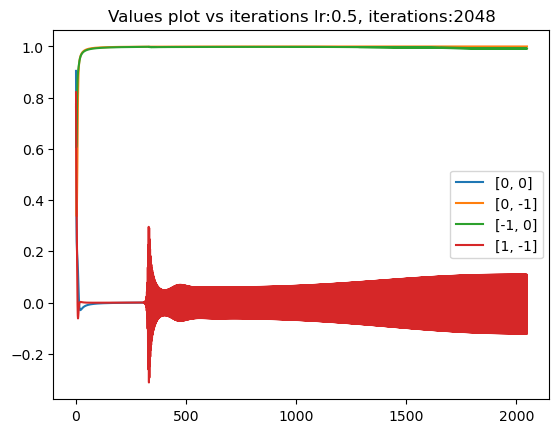

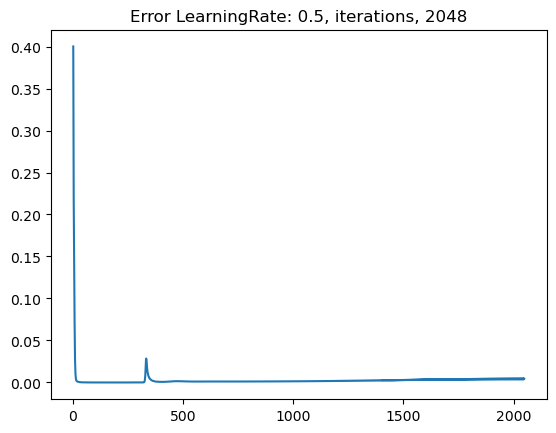

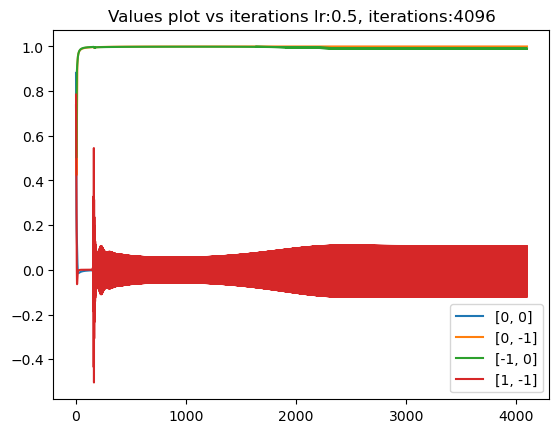

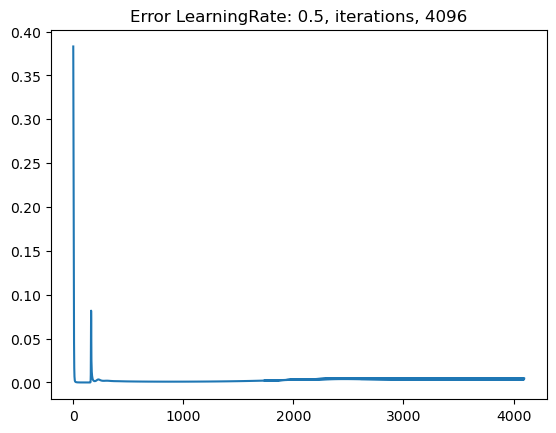

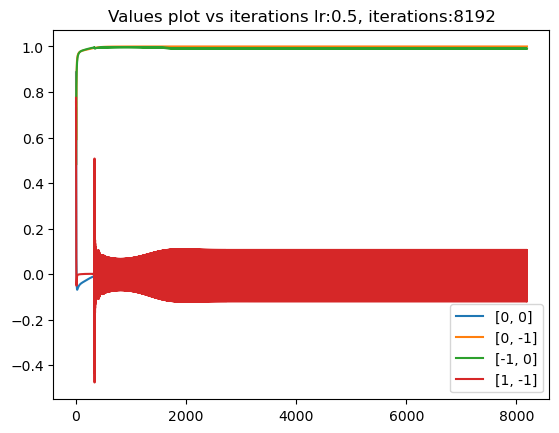

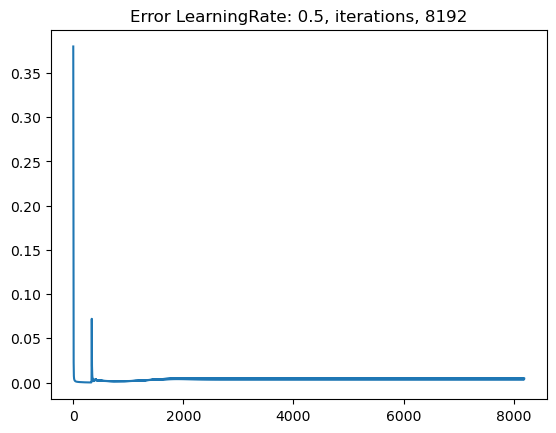

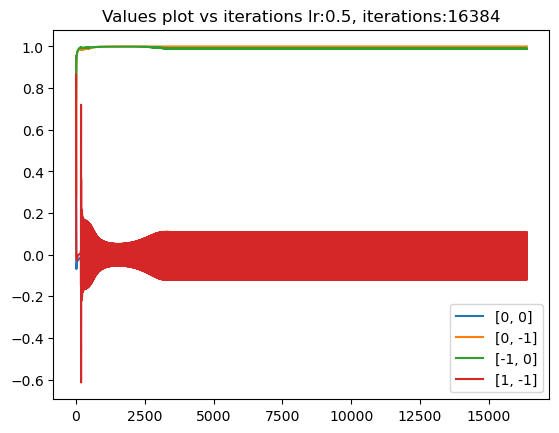

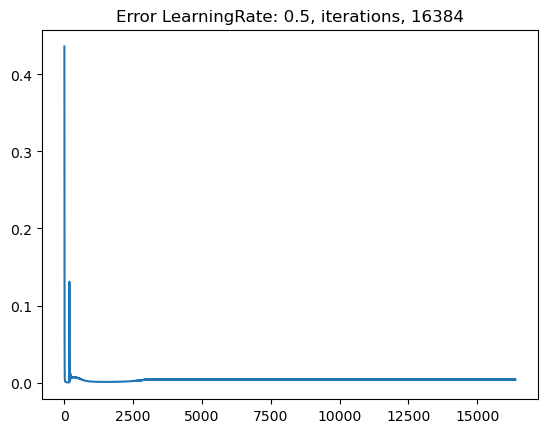

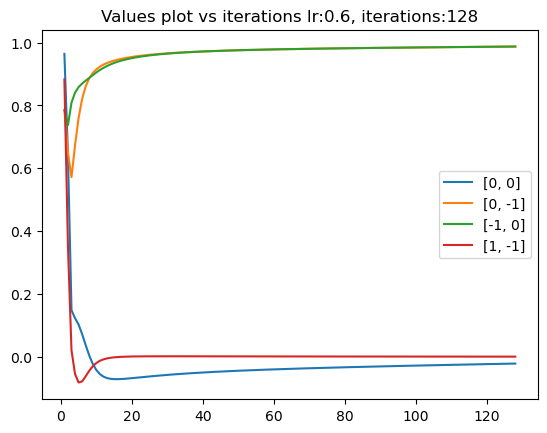

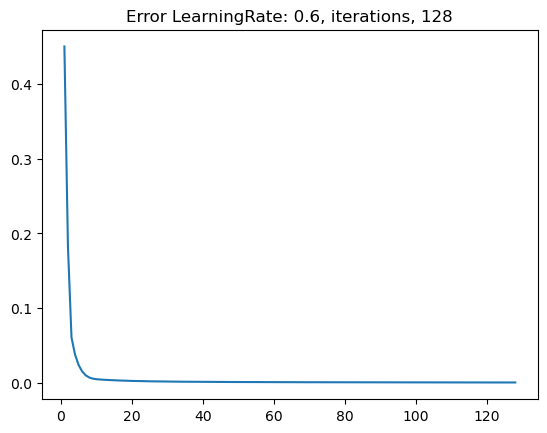

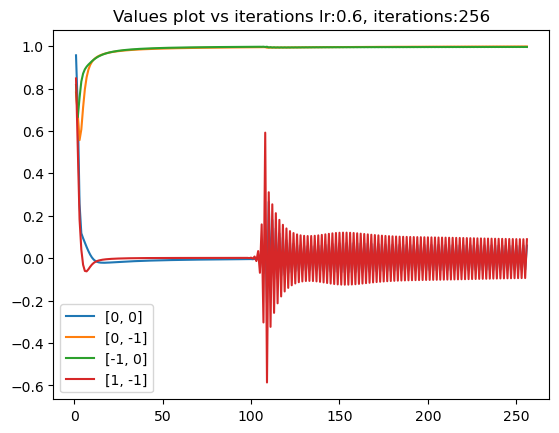

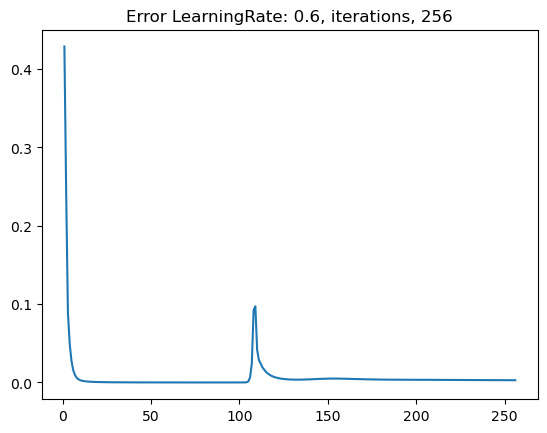

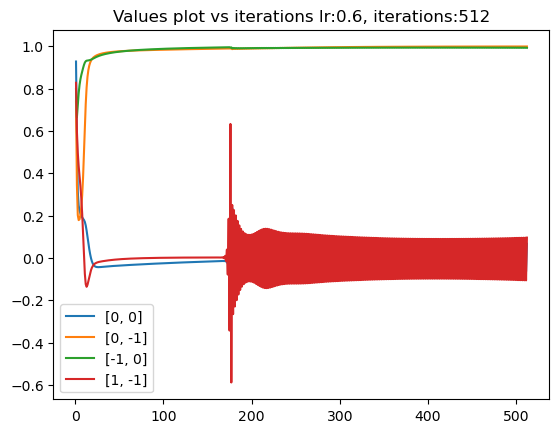

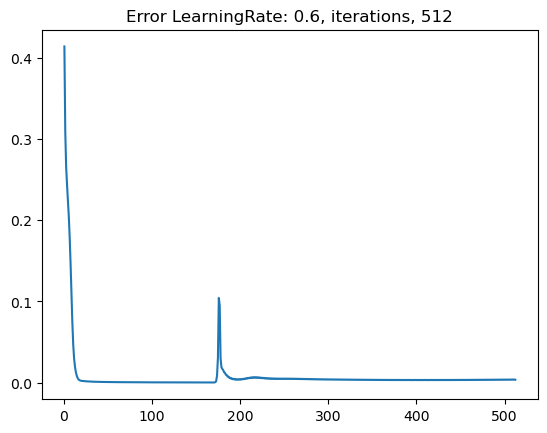

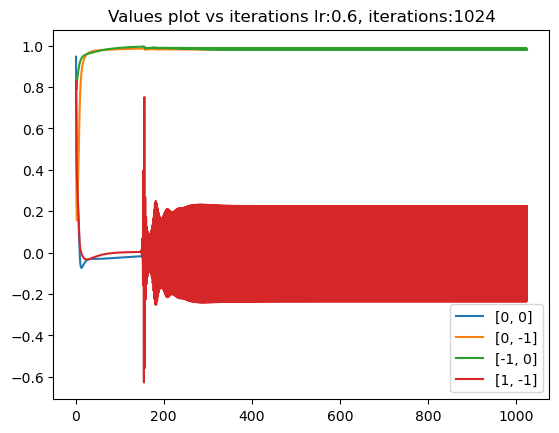

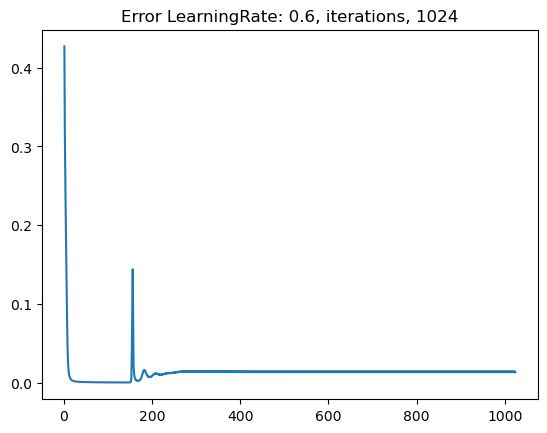

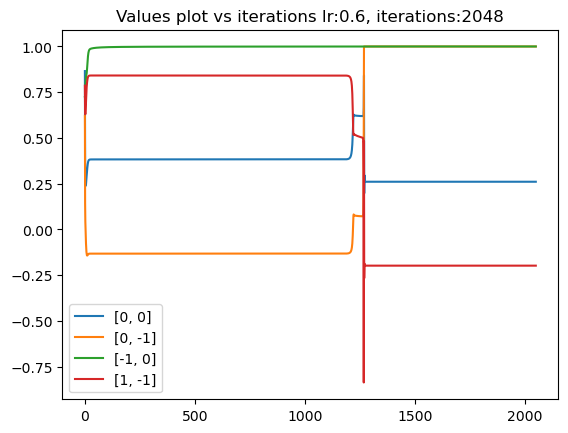

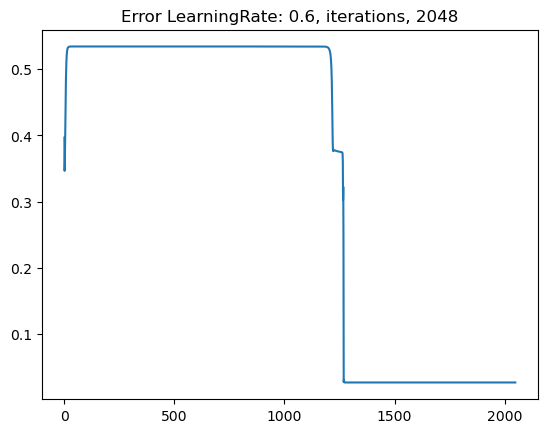

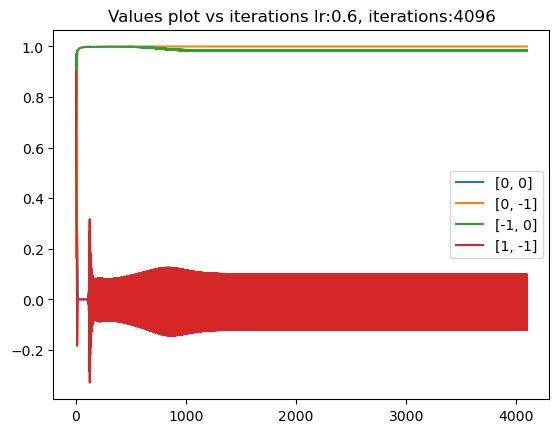

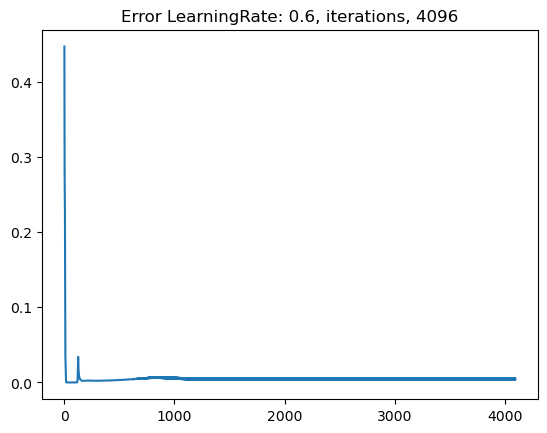

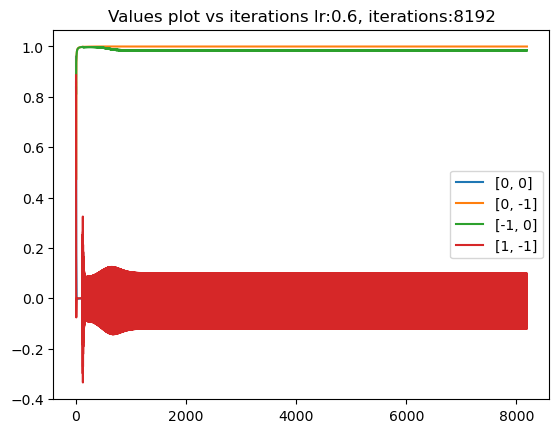

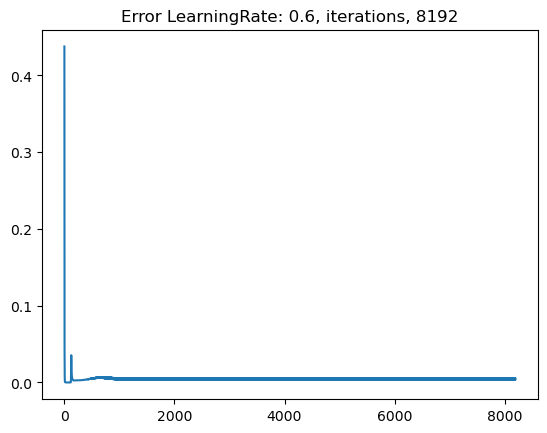

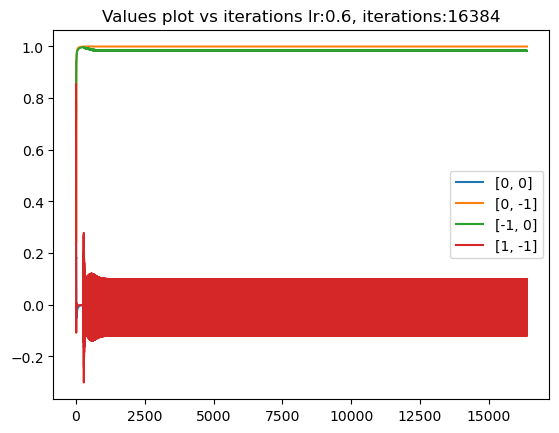

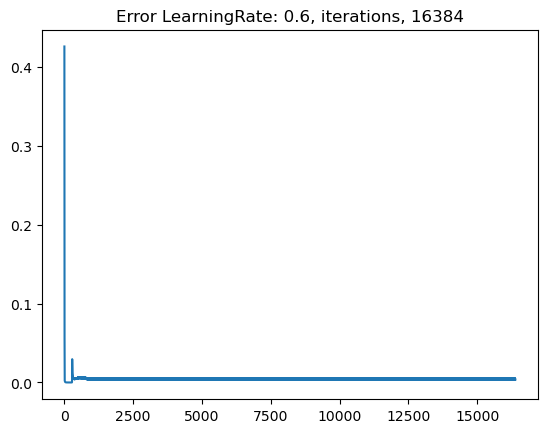

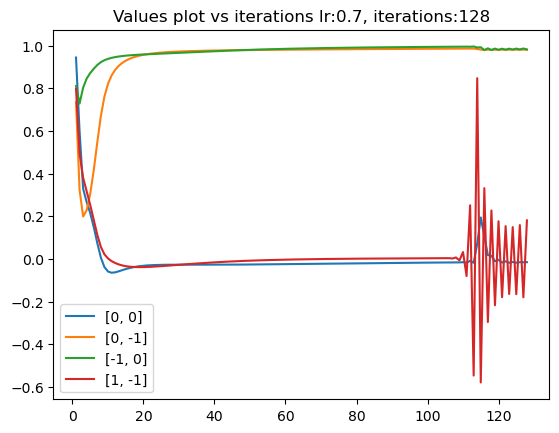

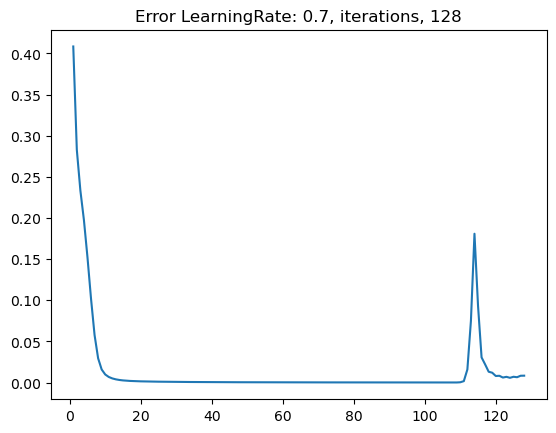

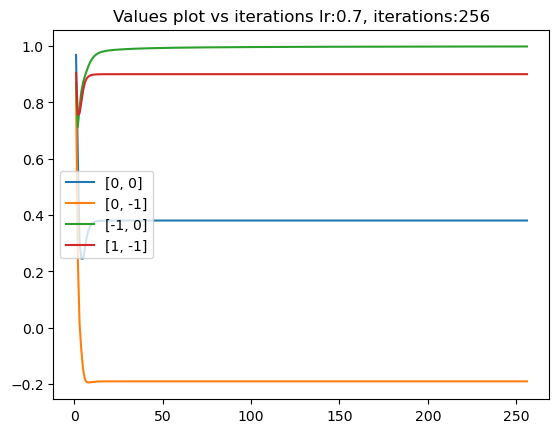

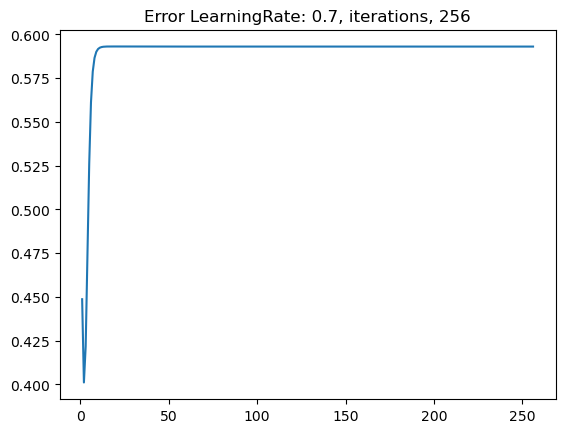

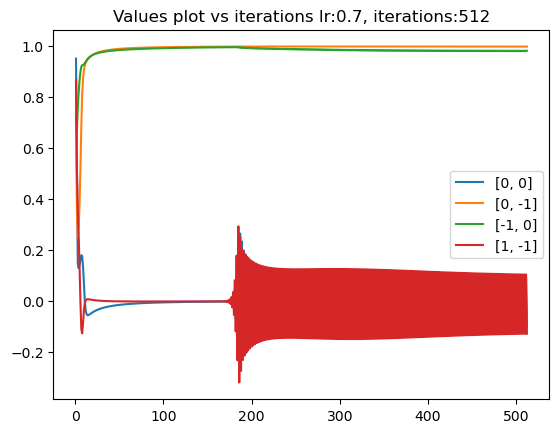

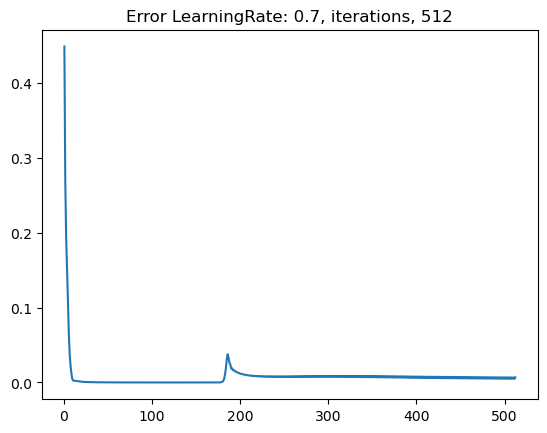

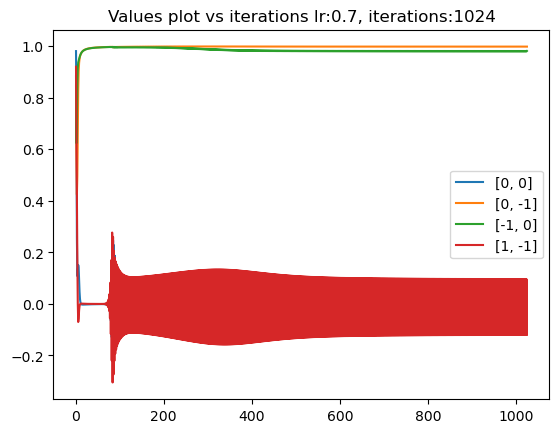

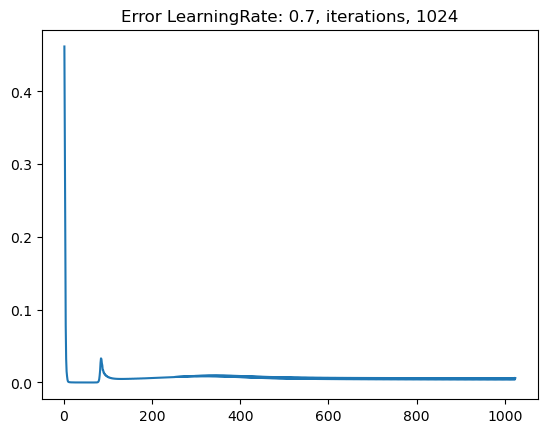

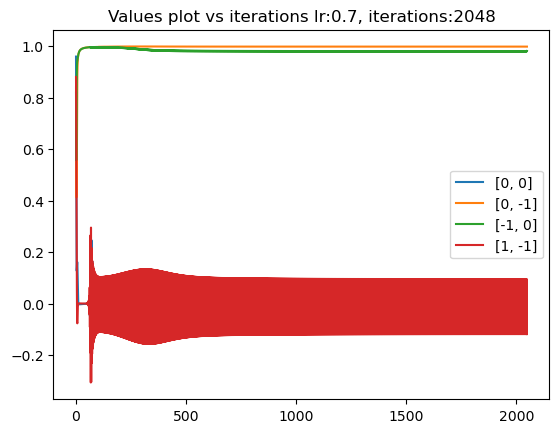

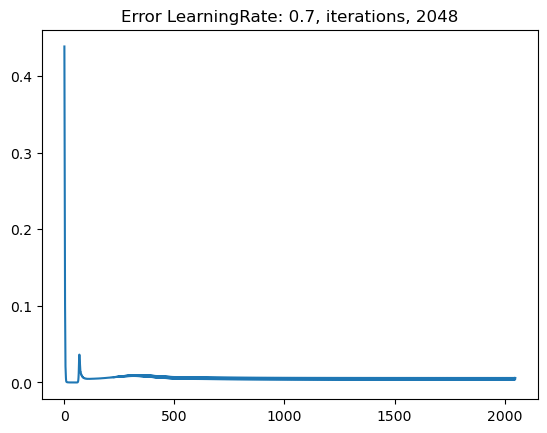

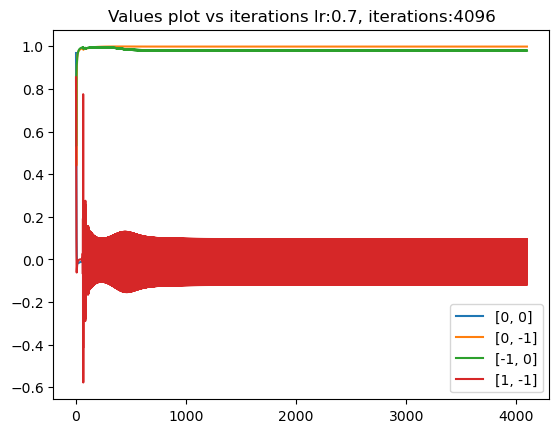

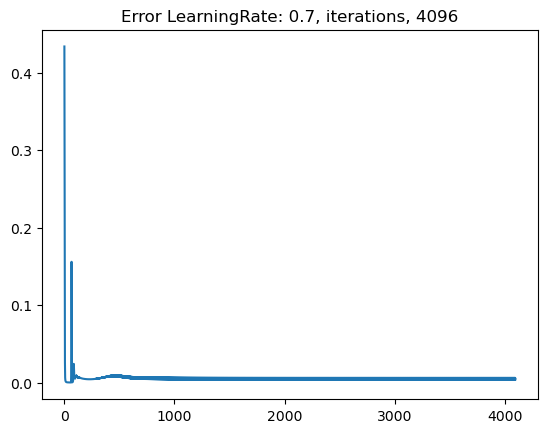

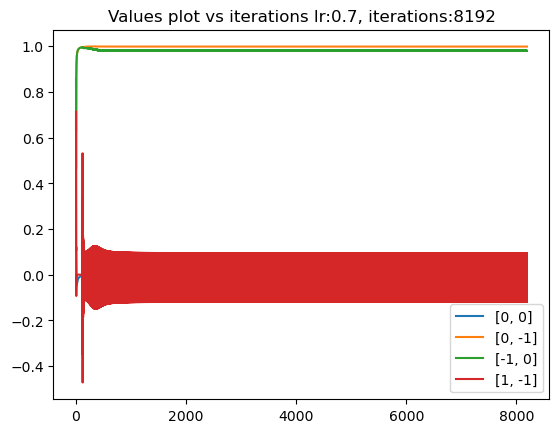

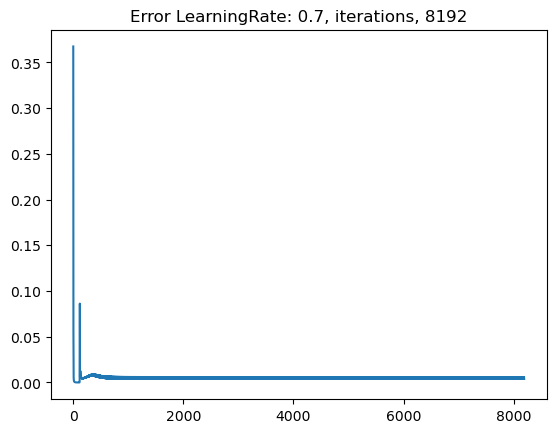

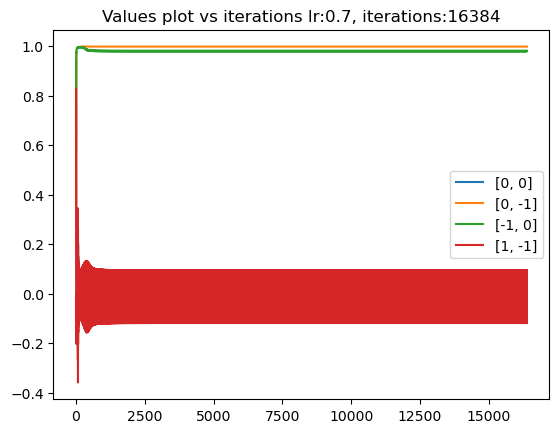

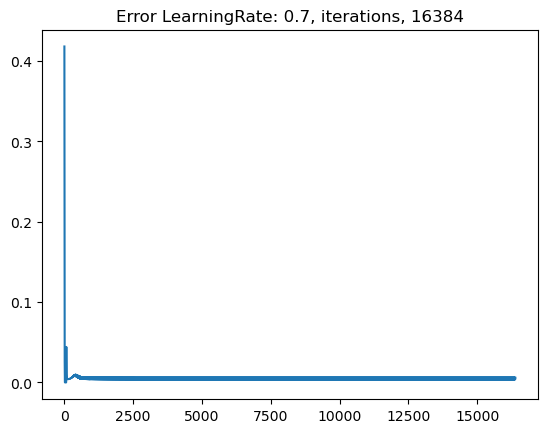

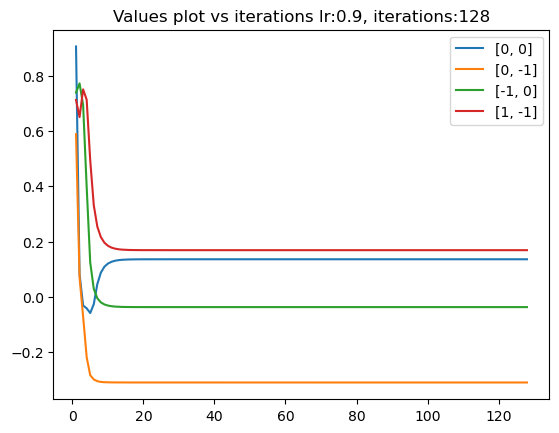

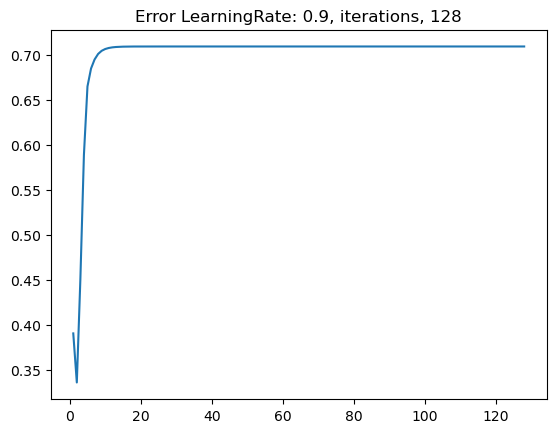

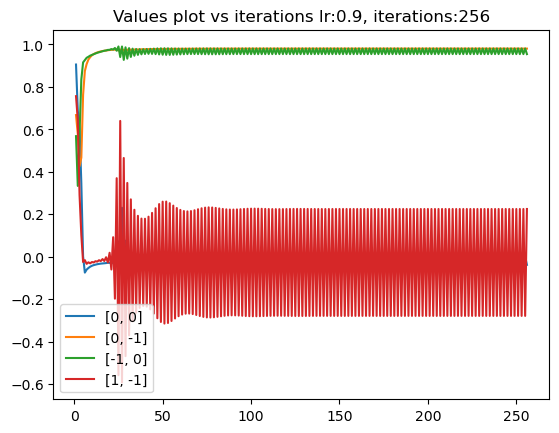

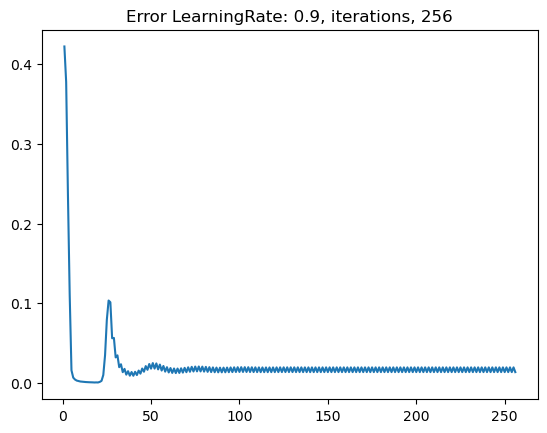

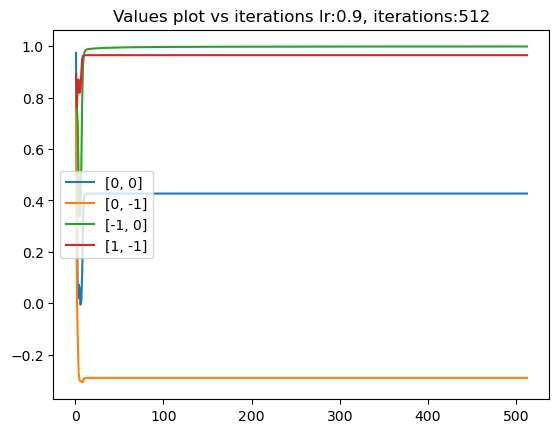

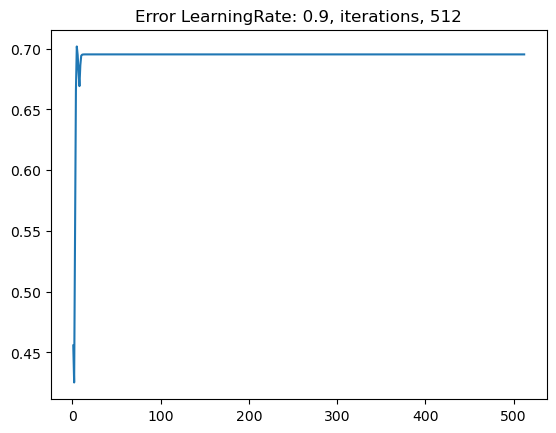

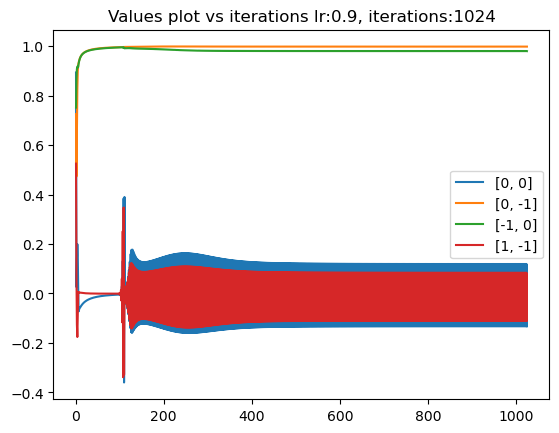

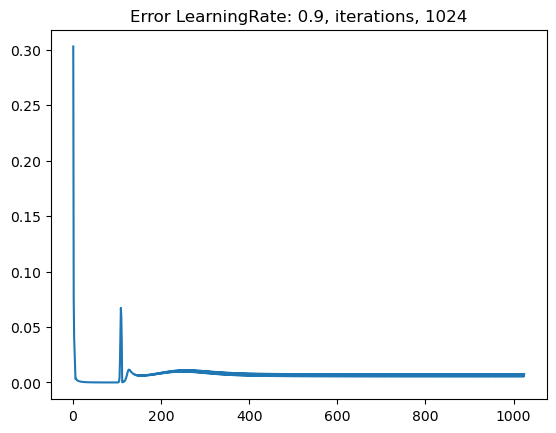

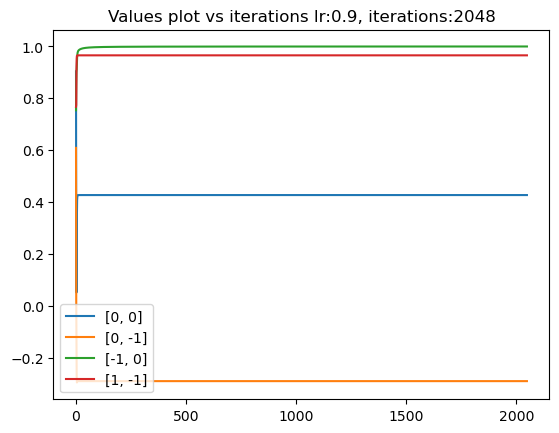

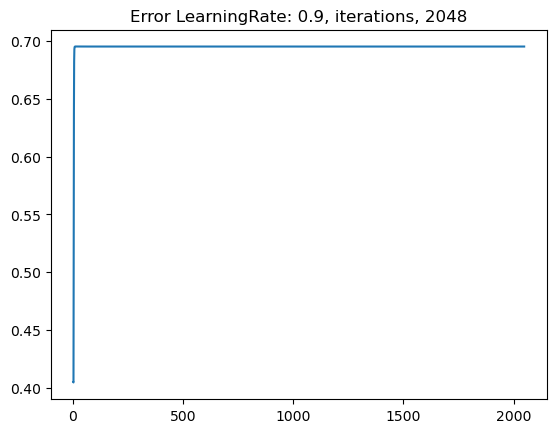

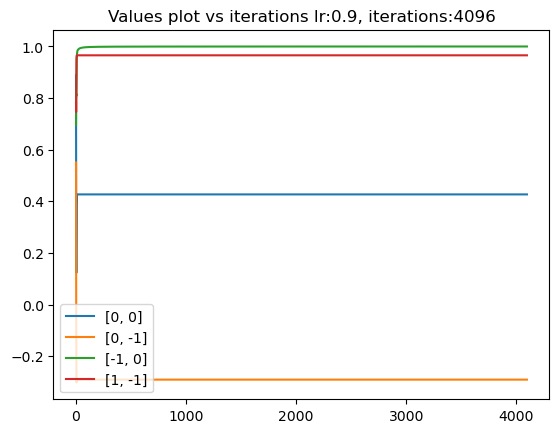

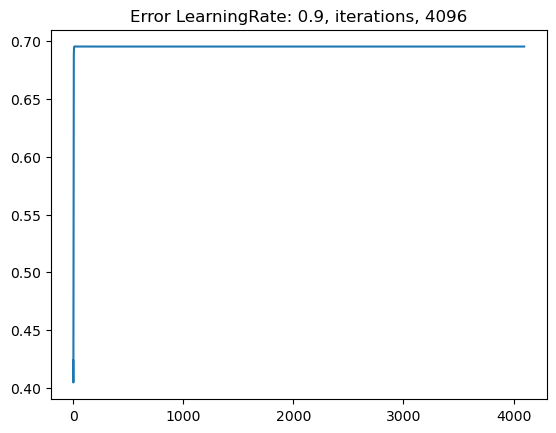

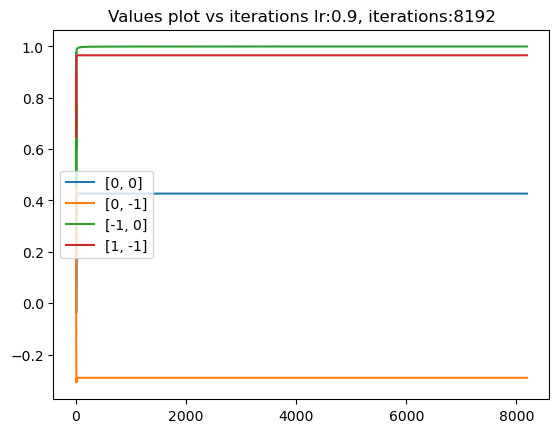

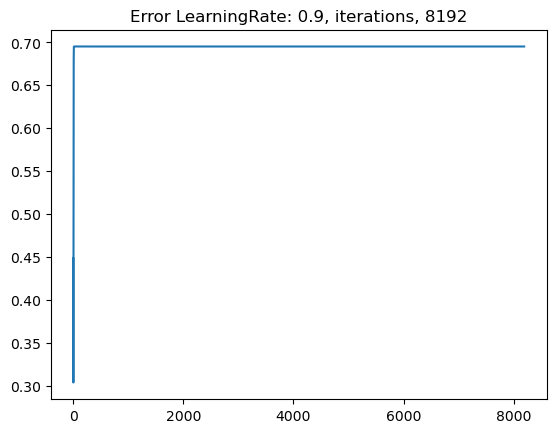

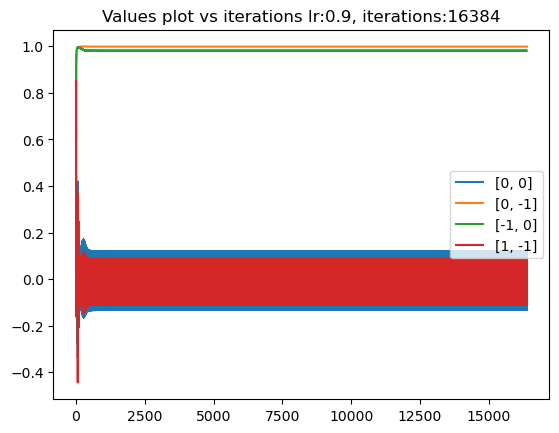

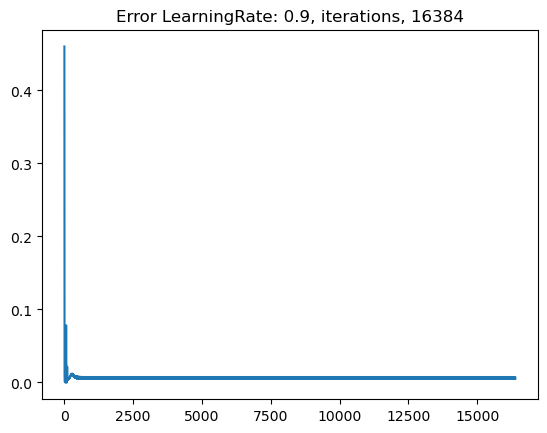

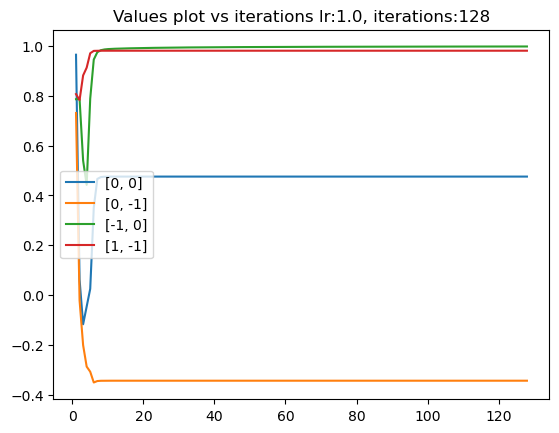

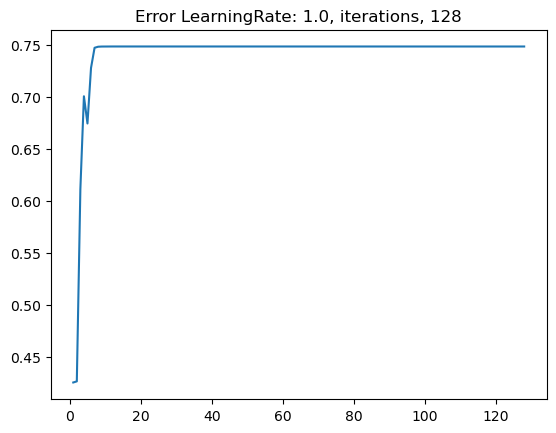

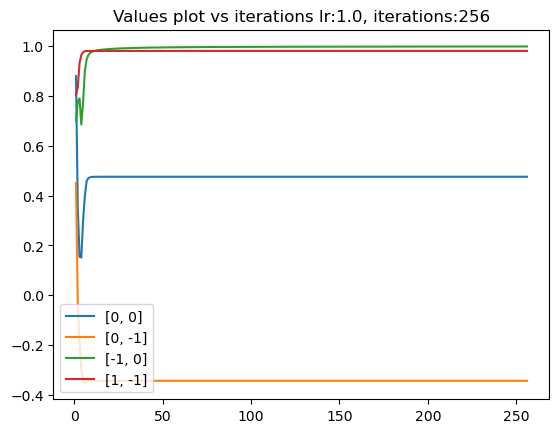

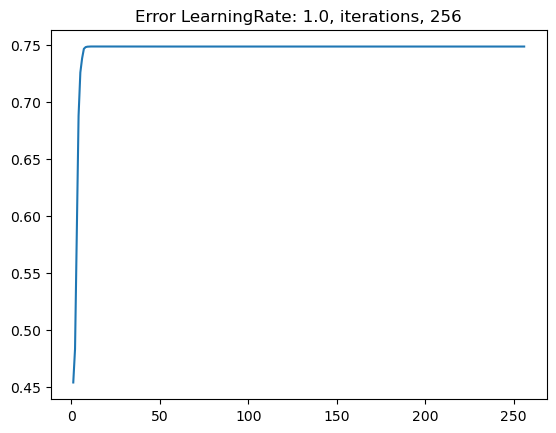

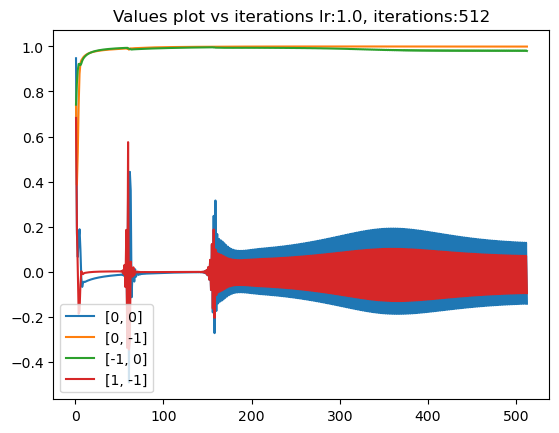

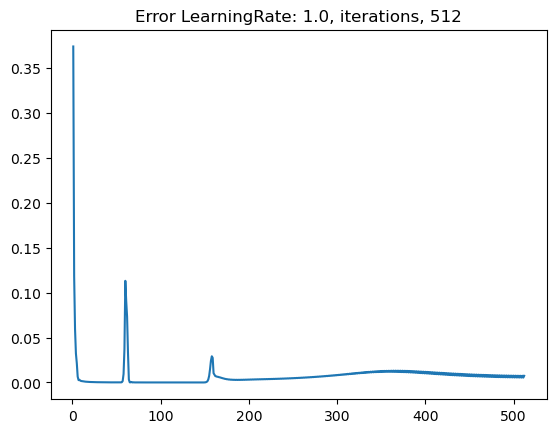

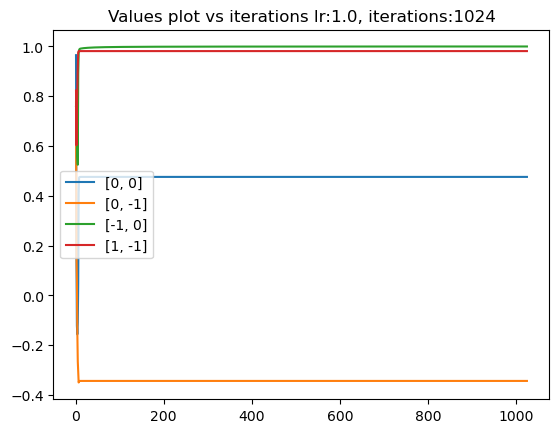

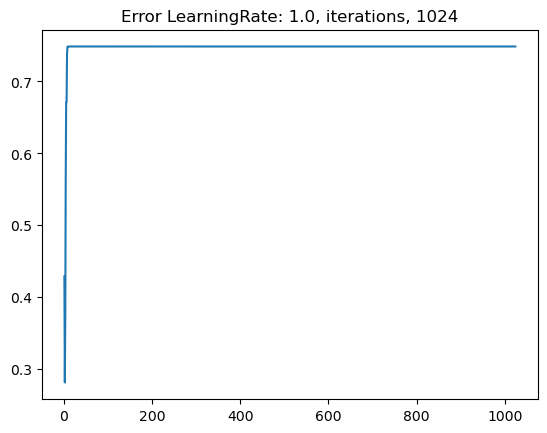

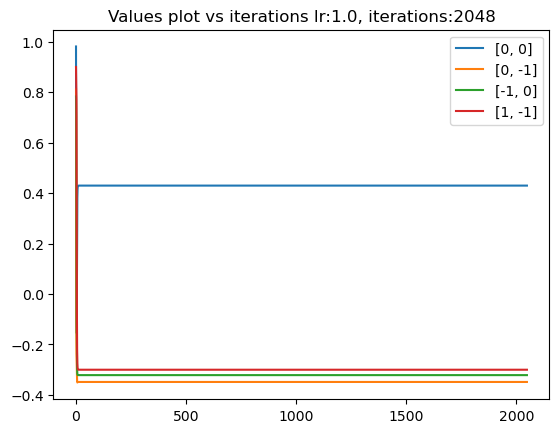

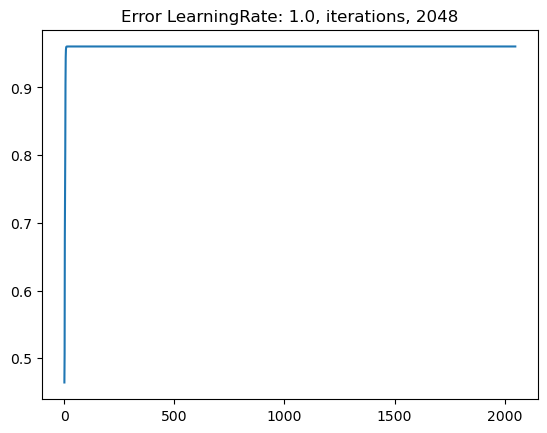

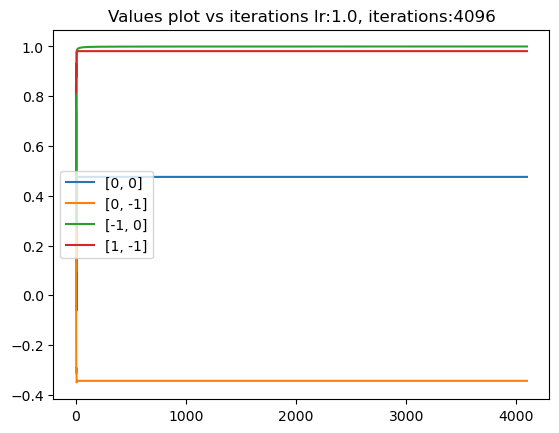

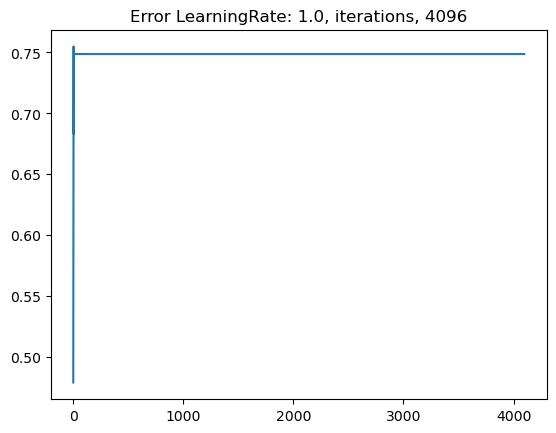

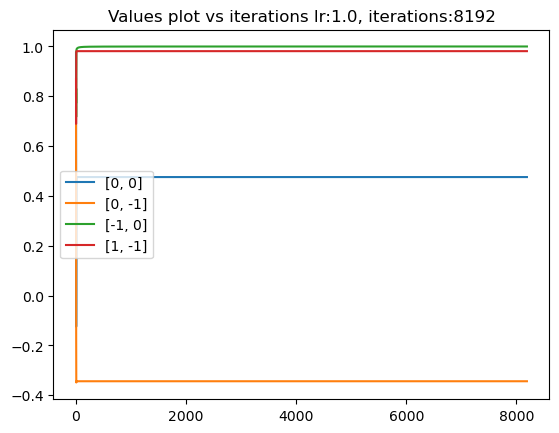

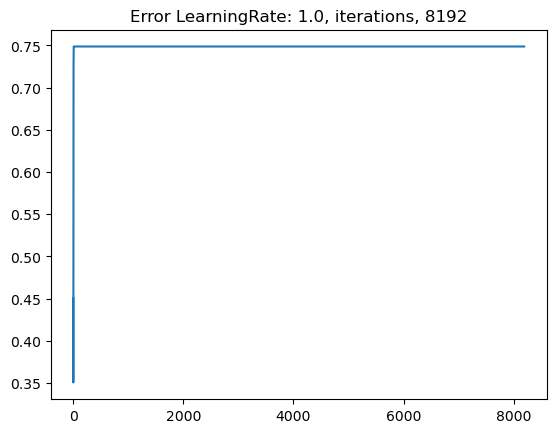

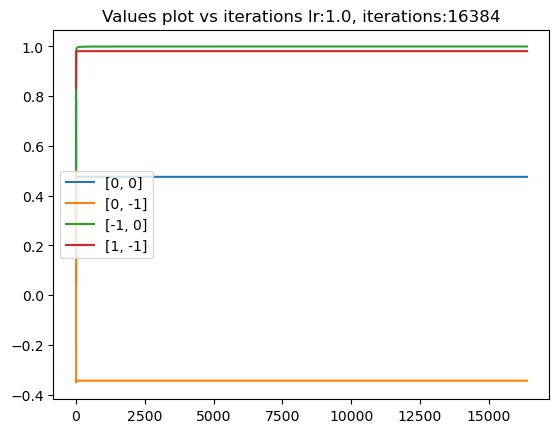

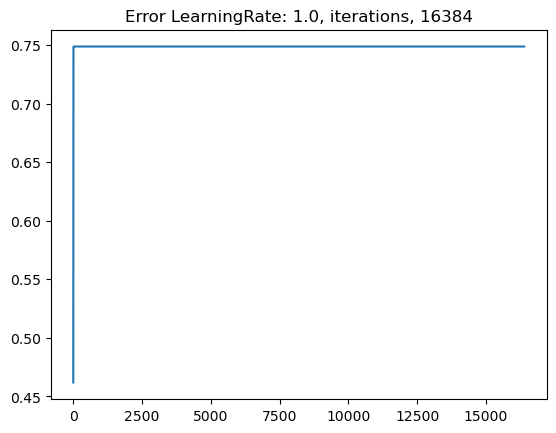

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.9,1.0
128,7.110238e-04,1.157463e-03,0.000111,6.376750e-06,0.000006,0.000189,0.009735,0.329925,0.192708
256,5.066116e-04,4.713063e-06,0.000001,8.443637e-07,0.015480,0.005341,0.203238,0.015748,0.192707
512,3.583259e-06,3.138157e-06,0.000001,7.142338e-04,0.000718,0.006786,0.015426,0.195143,0.026345
1024,2.474503e-06,3.793086e-06,0.001563,3.890851e-04,0.002567,0.013522,0.013445,0.022956,0.192707
2048,4.776806e-07,4.716913e-08,0.000252,3.227563e-04,0.007769,0.017300,0.013156,0.195143,0.195802
4096,4.300056e-08,4.516169e-04,0.000126,1.658132e-04,0.007518,0.009904,0.010320,0.195143,0.192707
8192,3.443732e-08,3.940198e-09,0.008358,1.307946e-04,0.007518,0.009904,0.010320,0.195143,0.192707
16384,3.568746e-09,7.594366e-10,0.000026,2.926721e-03,0.006366,0.007903,0.013137,0.017563,0.192707


In [616]:
import pandas as pd

learningRate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
iterations = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
dataset = []
df = pd.DataFrame(columns=learningRate)
for lr in learningRate:
    column = []
    for iteration in iterations:
        error = plotGraphs(lr=lr, iterations=iteration, nodeType="Tanh")
        column.append(error)
    df[lr] = column
df.index = iterations
df

In [617]:
df.style.highlight_min(color="teal")


,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.900000,1.000000
128,0.000711,0.001157,0.000111,0.000006,0.000006,0.000189,0.009735,0.329925,0.192708
256,0.000507,0.000005,0.000001,0.000001,0.015480,0.005341,0.203238,0.015748,0.192707
512,0.000004,0.000003,0.000001,0.000714,0.000718,0.006786,0.015426,0.195143,0.026345
1024,0.000002,0.000004,0.001563,0.000389,0.002567,0.013522,0.013445,0.022956,0.192707
2048,0.000000,0.000000,0.000252,0.000323,0.007769,0.017300,0.013156,0.195143,0.195802
4096,0.000000,0.000452,0.000126,0.000166,0.007518,0.009904,0.010320,0.195143,0.192707
8192,0.000000,0.000000,0.008358,0.000131,0.007518,0.009904,0.010320,0.195143,0.192707
16384,0.000000,0.000000,0.000026,0.002927,0.006366,0.007903,0.013137,0.017563,0.192707


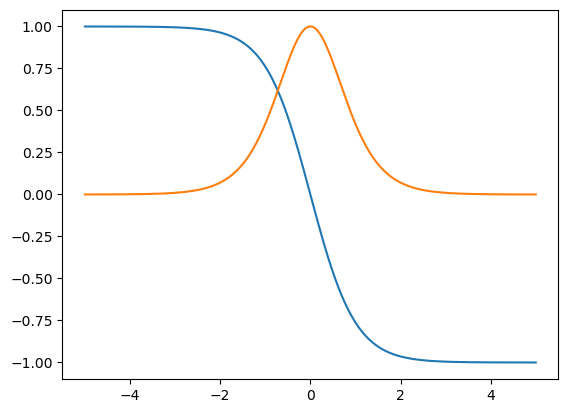

In [686]:
def float_range(start, stop, step):
  while start < stop:
    yield float(start)
    start += step

x = list(float_range(-5.0, 5.0, 0.01))
y = []
yp = []
for xp in x:
    y.append(np.tanh(-xp))
    yp.append(1 - np.tanh(-xp)**2)
plt.plot(x, y)
plt.plot(x, yp)